## Установка библиотек

In [ ]:
!pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 30.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.5 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.9-cp311-cp311-linux_x86_64.whl size=4123184 sha256=10509bed59f381ae693270f860583cd6388d70d56186b77ba80fa8b18ea822c7
  Stored in directory: /root/.cache/pip/wheels/9e/8f/bf/148c8eb7d69021eccd6eae6444f3accd48347587054ffd24e5
Successfully built llama-cpp-python


In [ ]:
!pip install -U datasets
!pip install bert-score
!pip install huggingface_hub
!pip install rouge_score
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 24.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
import time, psutil
from llama_cpp import Llama
from datasets import load_dataset
from difflib import SequenceMatcher
import pandas as pd
from bert_score import score as bert_score
import time, psutil, torch, json
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
from huggingface_hub import notebook_login
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from huggingface_hub import login
from transformers import pipeline
import gc

In [ ]:
import nltk
nltk.download('punkt', quiet=True)

True

In [ ]:
notebook_login()

## Quantization

In [ ]:
dataset_full = load_dataset("tatsu-lab/alpaca", split="train")

dataset = dataset_full.shuffle(seed=42).select(range(100))

In [ ]:
dataset

Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 15
})

In [ ]:
dataset.to_pandas()

,instruction,input,output,text
0,What would be the best type of exercise for a ...,,"For someone with arthritis, the best type of e...",Below is an instruction that describes a task....
1,Calculate the atomic mass for lithium.,,The atomic mass for lithium is 6.941 u (units)...,Below is an instruction that describes a task....
2,Convert the following binary code to ASCII cha...,01110101 01100001 01110010 01101001 01110100,The ASCII characters for the binary code is: w...,"Below is an instruction that describes a task,..."
3,Take this sentence and make it more descriptiv...,She was scared.,"She was trembling with fear, her heart racing ...","Below is an instruction that describes a task,..."
4,Brainstorm 3 possible ideas to promote the fol...,New motorized skateboard,1. Offer a free trial for a limited time.\n2. ...,"Below is an instruction that describes a task,..."
5,Rewrite the sentence using imperative mood.,Please pick up the book from the shelf.,Pick up the book from the shelf.,"Below is an instruction that describes a task,..."
6,Describe a picnic vacation where four people a...,Four people are travelling together to a picni...,The four friends decided to take a picnic vaca...,"Below is an instruction that describes a task,..."
7,Explain the concept of Big Data and what it me...,,Big Data is the massive volume of data that is...,Below is an instruction that describes a task....
8,Analyze the given phrase in terms of its conno...,Wild goose chase,"The phrase ""wild goose chase"" is typically use...","Below is an instruction that describes a task,..."
9,List three potential sources for the following...,What are the benefits of online learning?,1. Journal of Online Learning Research \n2. Ha...,"Below is an instruction that describes a task,..."


In [ ]:
variants = {
    "Q2_K": "mistral-7b-instruct-v0.1.Q2_K.gguf",
    "Q3_K_M": "mistral-7b-instruct-v0.1.Q3_K_M.gguf",
    "Q4_K_M": "mistral-7b-instruct-v0.1.Q4_K_M.gguf",
    "Q5_K_M": "mistral-7b-instruct-v0.1.Q5_K_S.gguf",
    "Q8_0": "mistral-7b-instruct-v0.1.Q8_0.gguf",
}

In [ ]:
repo_id = "TheBloke/Mistral-7B-Instruct-v0.1-GGUF"

In [ ]:
dataset.to_pandas()

,instruction,input,output,text
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,Below is an instruction that describes a task....


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
tokenizer_ppl = AutoTokenizer.from_pretrained("gpt2")
model_ppl = AutoModelForCausalLM.from_pretrained("gpt2").eval().cuda() if torch.cuda.is_available() else AutoModelForCausalLM.from_pretrained("gpt2").eval()

def calculate_perplexity(text):
    inputs = tokenizer_ppl(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model_ppl(**inputs, labels=inputs["input_ids"])
    return torch.exp(outputs.loss).item()

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
all_logs = []
df_list = []
model_inputs = []
proc = psutil.Process()

for variant, filename in variants.items():
    print(f"\n Evaluating {variant}...")

    mem_before_model = proc.memory_info().rss / 1024**2

    llm = Llama.from_pretrained(
        repo_id=repo_id,
        filename=filename,
    )

    mem_after_model = proc.memory_info().rss / 1024**2
    model_ram_MB = round(mem_after_model - mem_before_model, 2)
    print(f"Model loaded. RAM usage increased by: {model_ram_MB} MB")

    model_inputs.append({
        "model": variant,
        "model_load_RAM_MB": model_ram_MB
    })

    logs = []

    for item in dataset:
        prompt = item["instruction"]
        reference = item["output"]

        t0 = time.time()
        response = llm(prompt, max_tokens=100)["choices"][0]["text"].strip()
        t1 = time.time()

        prompt_tokens = len(tokenizer.encode(prompt))
        response_tokens = len(tokenizer.encode(response))
        total_tokens = prompt_tokens + response_tokens

        total_time = t1 - t0
        sec_per_token = total_time / max(response_tokens, 1)
        throughput = response_tokens / max(total_time, 1e-6)

        logs.append({
            "model": variant,
            "instruction": prompt,
            "reference": reference,
            "prediction": response,
            "gen_time_sec": round(total_time, 2),
            "prompt_tokens": prompt_tokens,
            "response_tokens": response_tokens,
            "total_tokens": total_tokens,
            "sec_per_token": round(sec_per_token, 4),
            "tokens_per_sec": round(throughput, 2),
        })

    df = pd.DataFrame(logs)
    df_list.append(df)
    all_logs.extend(logs)

final_df = pd.concat(df_list, ignore_index=True)


 Evaluating Q2_K...


llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.1-GGUF/snapshots/731a9fc8f06f5f5e2db8a0cf9d256197eb6e05d1/./mistral-7b-instruct-v0.1.Q2_K.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv

Model loaded. RAM usage increased by: 2940.57 MB


llama_perf_context_print:        load time =    1721.95 ms
llama_perf_context_print: prompt eval time =    1721.83 ms /    19 tokens (   90.62 ms per token,    11.03 tokens per second)
llama_perf_context_print:        eval time =    9750.62 ms /    91 runs   (  107.15 ms per token,     9.33 tokens per second)
llama_perf_context_print:       total time =   11513.76 ms /   110 tokens
Llama.generate: 1 prefix-match hit, remaining 10 prompt tokens to eval
llama_perf_context_print:        load time =    1721.95 ms
llama_perf_context_print: prompt eval time =    3252.46 ms /    10 tokens (  325.25 ms per token,     3.07 tokens per second)
llama_perf_context_print:        eval time =    1061.72 ms /    10 runs   (  106.17 ms per token,     9.42 tokens per second)
llama_perf_context_print:       total time =    4318.65 ms /    20 tokens
Llama.generate: 1 prefix-match hit, remaining 11 prompt tokens to eval
llama_perf_context_print:        load time =    1721.95 ms
llama_perf_context_print: pro


 Evaluating Q3_K_M...


llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.1-GGUF/snapshots/731a9fc8f06f5f5e2db8a0cf9d256197eb6e05d1/./mistral-7b-instruct-v0.1.Q3_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - 

Model loaded. RAM usage increased by: 4655.77 MB


llama_perf_context_print:        load time =    1418.92 ms
llama_perf_context_print: prompt eval time =    1418.78 ms /    19 tokens (   74.67 ms per token,    13.39 tokens per second)
llama_perf_context_print:        eval time =    9066.82 ms /    79 runs   (  114.77 ms per token,     8.71 tokens per second)
llama_perf_context_print:       total time =   10521.97 ms /    98 tokens
Llama.generate: 1 prefix-match hit, remaining 10 prompt tokens to eval
llama_perf_context_print:        load time =    1418.92 ms
llama_perf_context_print: prompt eval time =     685.42 ms /    10 tokens (   68.54 ms per token,    14.59 tokens per second)
llama_perf_context_print:        eval time =   11720.44 ms /    99 runs   (  118.39 ms per token,     8.45 tokens per second)
llama_perf_context_print:       total time =   12450.88 ms /   109 tokens
Llama.generate: 1 prefix-match hit, remaining 11 prompt tokens to eval
llama_perf_context_print:        load time =    1418.92 ms
llama_perf_context_print: pro


 Evaluating Q4_K_M...


mistral-7b-instruct-v0.1.Q4_K_M.gguf:   0%|          | 0.00/4.37G [00:00<?, ?B/s]

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.1-GGUF/snapshots/731a9fc8f06f5f5e2db8a0cf9d256197eb6e05d1/./mistral-7b-instruct-v0.1.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - 

Model loaded. RAM usage increased by: 7368.73 MB


llama_perf_context_print:        load time =    3351.22 ms
llama_perf_context_print: prompt eval time =    3351.09 ms /    19 tokens (  176.37 ms per token,     5.67 tokens per second)
llama_perf_context_print:        eval time =   17344.75 ms /    92 runs   (  188.53 ms per token,     5.30 tokens per second)
llama_perf_context_print:       total time =   20770.86 ms /   111 tokens
Llama.generate: 1 prefix-match hit, remaining 10 prompt tokens to eval
llama_perf_context_print:        load time =    3351.22 ms
llama_perf_context_print: prompt eval time =    1195.42 ms /    10 tokens (  119.54 ms per token,     8.37 tokens per second)
llama_perf_context_print:        eval time =   16303.75 ms /    98 runs   (  166.36 ms per token,     6.01 tokens per second)
llama_perf_context_print:       total time =   17561.53 ms /   108 tokens
Llama.generate: 1 prefix-match hit, remaining 11 prompt tokens to eval
llama_perf_context_print:        load time =    3351.22 ms
llama_perf_context_print: pro


 Evaluating Q5_K_M...


mistral-7b-instruct-v0.1.Q5_K_S.gguf:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.1-GGUF/snapshots/731a9fc8f06f5f5e2db8a0cf9d256197eb6e05d1/./mistral-7b-instruct-v0.1.Q5_K_S.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - 

Model loaded. RAM usage increased by: 4766.13 MB


llama_perf_context_print:        load time =    2205.16 ms
llama_perf_context_print: prompt eval time =    2205.00 ms /    19 tokens (  116.05 ms per token,     8.62 tokens per second)
llama_perf_context_print:        eval time =   16500.91 ms /    93 runs   (  177.43 ms per token,     5.64 tokens per second)
llama_perf_context_print:       total time =   18750.39 ms /   112 tokens
Llama.generate: 1 prefix-match hit, remaining 10 prompt tokens to eval
llama_perf_context_print:        load time =    2205.16 ms
llama_perf_context_print: prompt eval time =    1101.24 ms /    10 tokens (  110.12 ms per token,     9.08 tokens per second)
llama_perf_context_print:        eval time =   17047.32 ms /    99 runs   (  172.20 ms per token,     5.81 tokens per second)
llama_perf_context_print:       total time =   18193.84 ms /   109 tokens
Llama.generate: 1 prefix-match hit, remaining 11 prompt tokens to eval
llama_perf_context_print:        load time =    2205.16 ms
llama_perf_context_print: pro


 Evaluating Q8_0...


mistral-7b-instruct-v0.1.Q8_0.gguf:   0%|          | 0.00/7.70G [00:00<?, ?B/s]

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.1-GGUF/snapshots/731a9fc8f06f5f5e2db8a0cf9d256197eb6e05d1/./mistral-7b-instruct-v0.1.Q8_0.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv

Model loaded. RAM usage increased by: 7307.61 MB


llama_perf_context_print:        load time =    2042.80 ms
llama_perf_context_print: prompt eval time =    2042.62 ms /    19 tokens (  107.51 ms per token,     9.30 tokens per second)
llama_perf_context_print:        eval time =   23344.81 ms /    99 runs   (  235.81 ms per token,     4.24 tokens per second)
llama_perf_context_print:       total time =   25434.66 ms /   118 tokens
Llama.generate: 1 prefix-match hit, remaining 10 prompt tokens to eval
llama_perf_context_print:        load time =    2042.80 ms
llama_perf_context_print: prompt eval time =     721.46 ms /    10 tokens (   72.15 ms per token,    13.86 tokens per second)
llama_perf_context_print:        eval time =   23546.83 ms /    99 runs   (  237.85 ms per token,     4.20 tokens per second)
llama_perf_context_print:       total time =   24315.12 ms /   109 tokens
Llama.generate: 1 prefix-match hit, remaining 11 prompt tokens to eval
llama_perf_context_print:        load time =    2042.80 ms
llama_perf_context_print: pro

In [ ]:
final_df

,model,instruction,reference,prediction,gen_time_sec,tokens,sec_per_token,mem_usage_MB,perplexity,bertscore_f1
0,Q2_K,What would be the best type of exercise for a ...,"For someone with arthritis, the best type of e...","Low impact exercises such as swimming, walking...",15.83,72,0.2199,-7401.82,12.17,89.86
1,Q2_K,Calculate the atomic mass for lithium.,The atomic mass for lithium is 6.941 u (units)...,Answer: 6.941,2.70,2,1.3503,0.00,111.83,83.44
2,Q2_K,Convert the following binary code to ASCII cha...,The ASCII characters for the binary code is: w...,01101100\n\nThe ASCII character for 01101100 i...,4.15,8,0.5193,0.00,62.07,86.50
3,Q2_K,Take this sentence and make it more descriptiv...,"She was trembling with fear, her heart racing ...","She was visibly trembling with fear, her heart...",4.49,23,0.1952,0.00,17.42,92.46
4,Q2_K,Brainstorm 3 possible ideas to promote the fol...,1. Offer a free trial for a limited time.\n2. ...,:\n\n1. Create an interactive social media cam...,12.17,73,0.1667,0.00,12.40,85.32
...,...,...,...,...,...,...,...,...,...,...
70,Q8_0,Arrange the following countries in ascending o...,"India, China, Japan, US",1. USA\n2. China\n3. Japan\n4. UK\n5. France\n...,18.27,48,0.3806,0.00,5.25,83.36
71,Q8_0,Name the boat depicted in the provided photo.,The boat in the photo is a sailboat.,A: The Name of the Boat is not specified in th...,3.46,12,0.2885,0.00,43.34,89.64
72,Q8_0,Edit the grammar and punctuation of the given ...,Humor is one of the most important ingredients...,A sentence is given. It needs to be edited.\nT...,4.48,15,0.2984,0.00,26.08,85.63
73,Q8_0,Calculate the length of the hypotenuse in the ...,The length of the hypotenuse in the triangle i...,The triangle has legs of length 7 and 8.\n\nWe...,18.95,72,0.2632,0.00,11.59,91.60


In [ ]:
final_df.to_csv("mistral_results.csv")

## Visualization

In [ ]:
df = pd.read_csv("/content/mistral_results-3.csv")

In [ ]:
df

,Unnamed: 0,model,instruction,reference,prediction,gen_time_sec,prompt_tokens,response_tokens,total_tokens,sec_per_token,tokens_per_sec,bertscore_f1,perplexity
0,0,Q2_K,What would be the best type of exercise for a ...,"For someone with arthritis, the best type of e...","Low impact exercises such as swimming, walking...",11.52,19,92,111,0.1252,7.99,89.86,12.17
1,1,Q2_K,Calculate the atomic mass for lithium.,The atomic mass for lithium is 6.941 u (units)...,Answer: 6.941,4.32,11,9,20,0.4802,2.08,83.44,111.83
2,2,Q2_K,Convert the following binary code to ASCII cha...,The ASCII characters for the binary code is: w...,01101100\n\nThe ASCII character for 01101100 i...,4.16,12,31,43,0.1342,7.45,86.50,62.07
3,3,Q2_K,Take this sentence and make it more descriptiv...,"She was trembling with fear, her heart racing ...","She was visibly trembling with fear, her heart...",4.39,16,30,46,0.1463,6.84,92.46,17.42
4,4,Q2_K,Brainstorm 3 possible ideas to promote the fol...,1. Offer a free trial for a limited time.\n2. ...,:\n\n1. Create an interactive social media cam...,11.45,13,101,114,0.1133,8.82,85.32,12.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,Q8_0,Come up with 5 new ideas for a product design.,- A product that combines headphones and a Blu...,"1. ""Smart"" Mirror: A mirror that integrates sm...",23.53,13,100,113,0.2353,4.25,85.61,29.85
496,496,Q8_0,"Provide a context to this sentence: ""He sugges...","In the lecture, Professor Smith was discussing...","In a science class, a group of students were d...",23.82,15,99,114,0.2406,4.16,84.74,15.82
497,497,Q8_0,Describe the main differences between a voice ...,A voice assistant can understand spoken comman...,A voice assistant is a digital assistant that ...,13.40,17,54,71,0.2481,4.03,88.00,23.26
498,498,Q8_0,Edit the following sentence to make it more fo...,I have been the unfortunate victim of a stolen...,"-> ""Unfortunately, my mobile device was stolen...",6.98,26,25,51,0.2792,3.58,91.31,32.45


In [ ]:
def compute_bleu(reference, prediction):
    reference = [reference.strip().split()]
    prediction = prediction.strip().split()
    smoothing = SmoothingFunction().method1
    return sentence_bleu(reference, prediction, smoothing_function=smoothing) * 100  # в %

rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_rouge_l(reference, prediction):
    scores = rouge.score(reference, prediction)
    return scores["rougeL"].fmeasure * 100  # в %

df["bleu_score"] = df.apply(lambda row: compute_bleu(str(row["reference"]), str(row["prediction"])), axis=1)
df["rouge_l_score"] = df.apply(lambda row: compute_rouge_l(str(row["reference"]), str(row["prediction"])), axis=1)

P, R, F1 = bert_score(df["prediction"].astype(str).tolist(), df["reference"].astype(str).tolist(), lang="en", verbose=True)

df["bertscore_f1"] = [round(f.item() * 100, 2) for f in F1]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/9 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/8 [00:00<?, ?it/s]

done in 190.19 seconds, 2.63 sentences/sec


In [ ]:
grouped = df.groupby("model")[[
    "bertscore_f1", "bleu_score", "rouge_l_score", "perplexity", "sec_per_token"
]].mean().round(2).reset_index()

In [ ]:
grouped

,model,bertscore_f1,bleu_score,rouge_l_score,perplexity,sec_per_token
0,Q2_K,86.03,2.91,20.13,67.44,0.14
1,Q3_K_M,86.26,3.66,20.55,48.14,0.15
2,Q4_K_M,86.14,3.81,20.28,52.47,0.17
3,Q5_K_M,86.35,3.27,20.17,41.64,0.22
4,Q8_0,86.27,3.23,20.45,44.69,0.28


<ipython-input-17-438196080>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x="model", y=metric, palette="Set2")


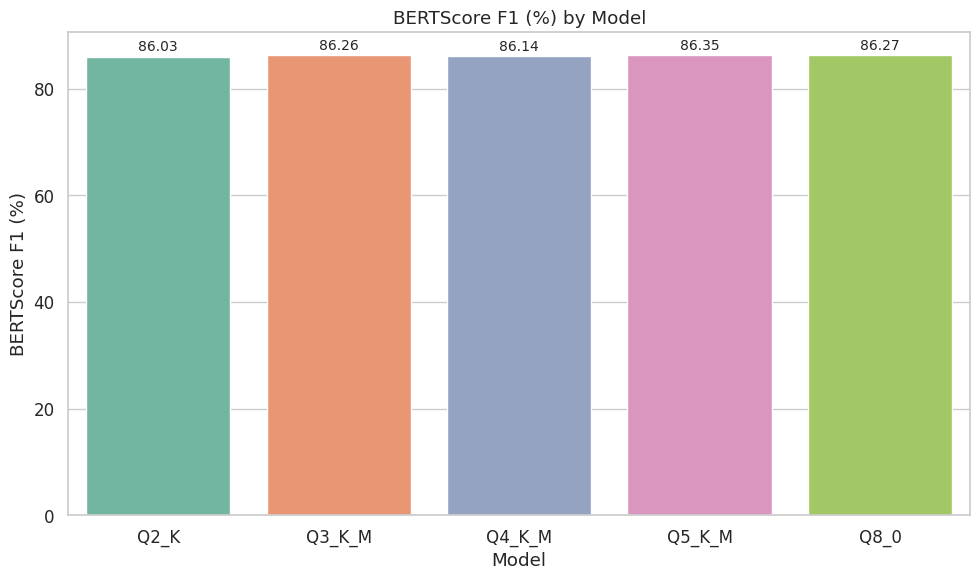

<ipython-input-17-438196080>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x="model", y=metric, palette="Set2")


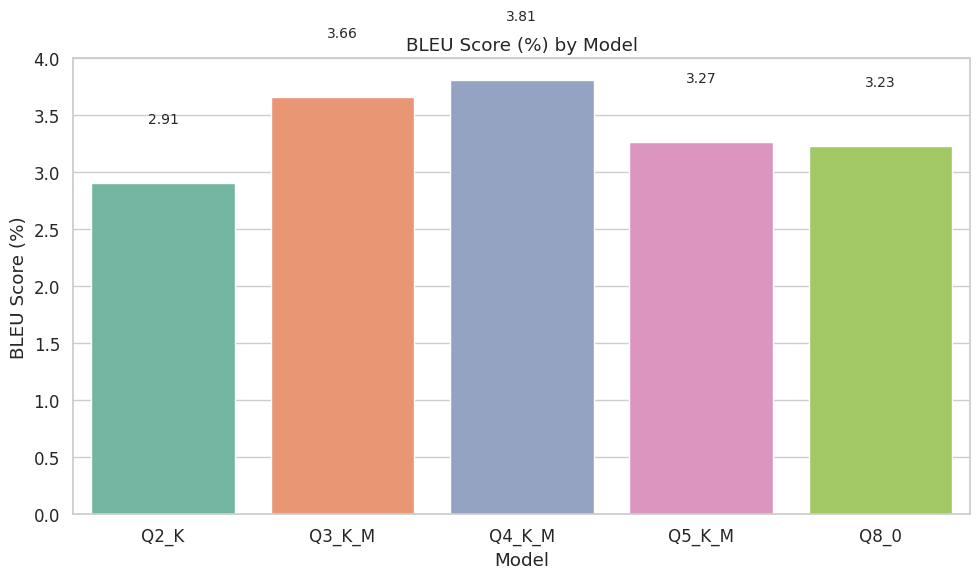

<ipython-input-17-438196080>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x="model", y=metric, palette="Set2")


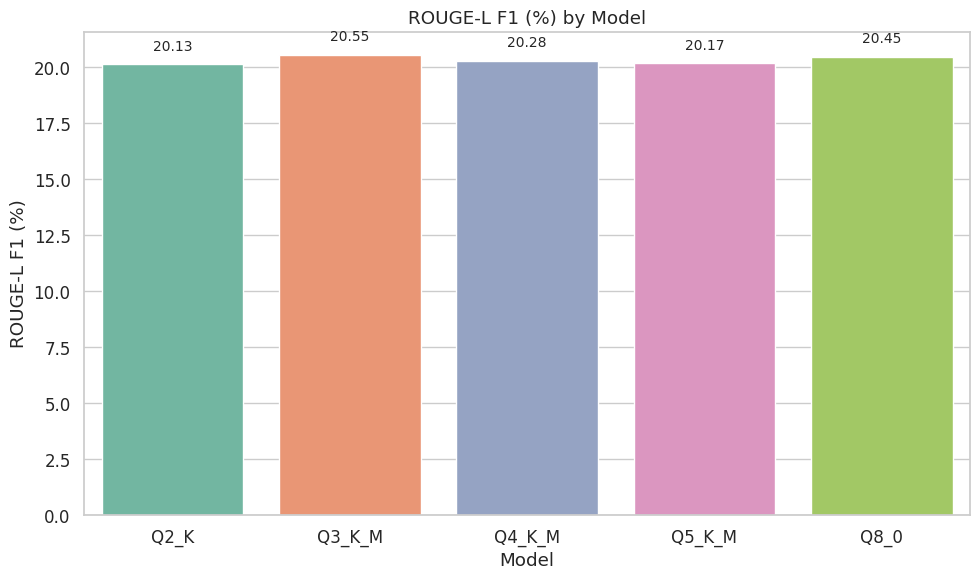

<ipython-input-17-438196080>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x="model", y=metric, palette="Set2")


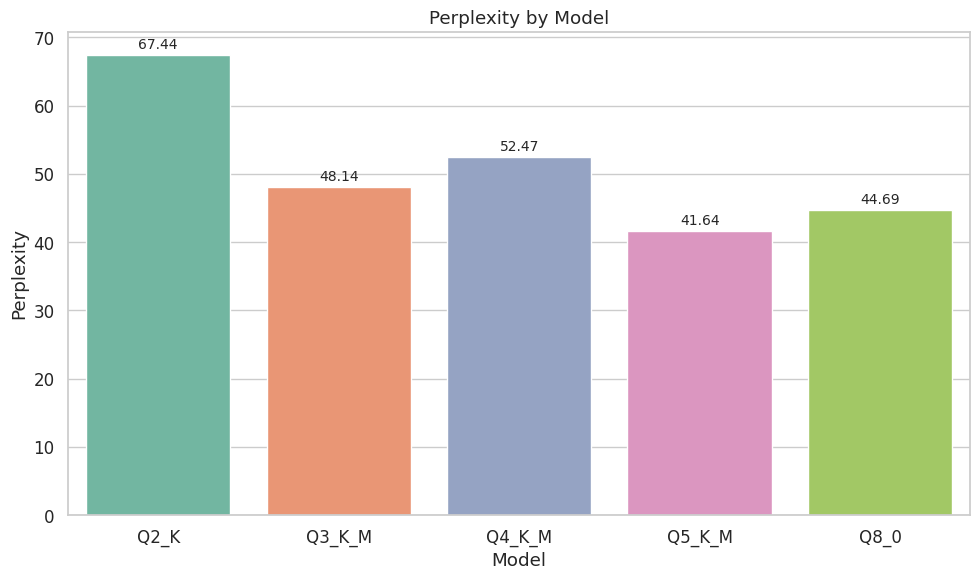

<ipython-input-17-438196080>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x="model", y=metric, palette="Set2")
<ipython-input-17-438196080>:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


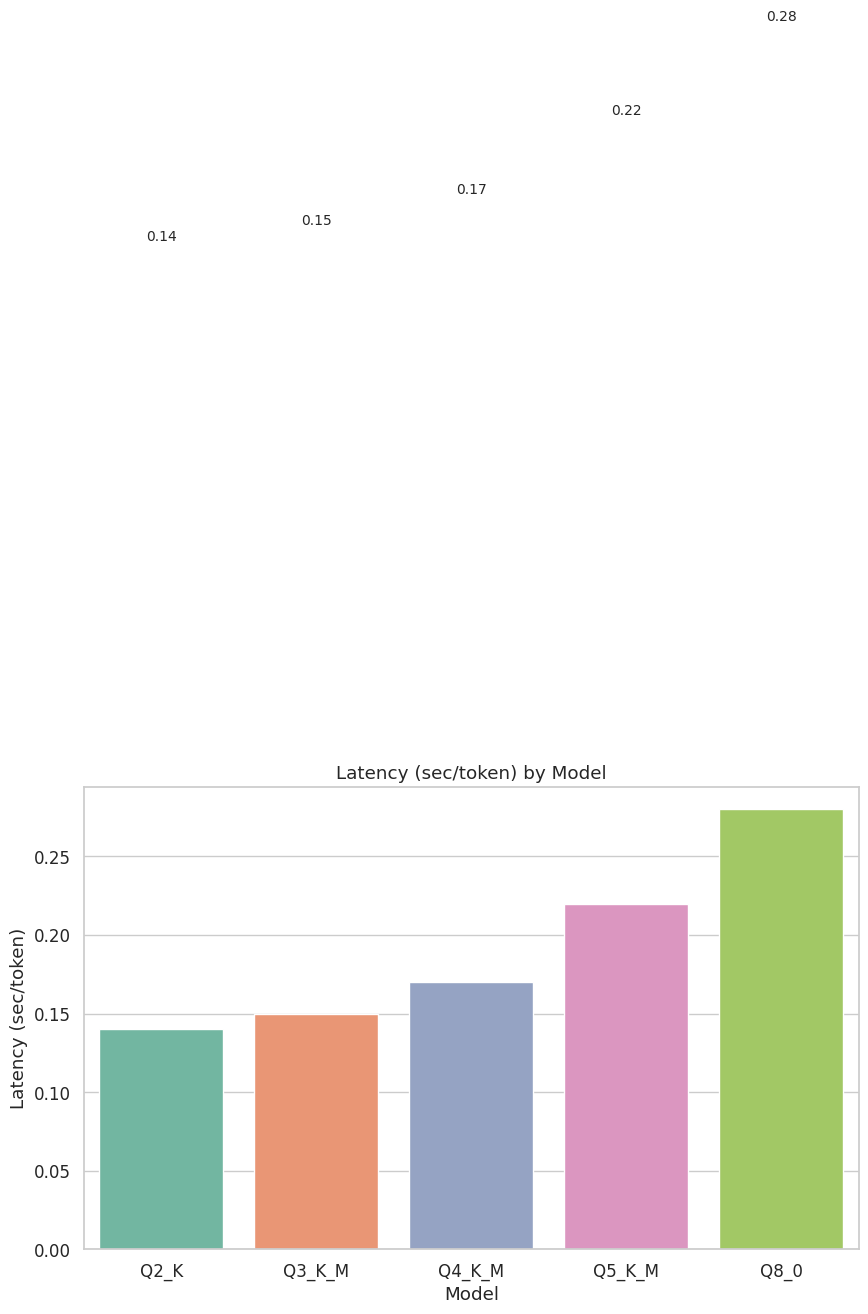

In [ ]:
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

metrics = ["bertscore_f1", "bleu_score", "rouge_l_score", "perplexity", "sec_per_token"]
titles = [
    "BERTScore F1 (%)",
    "BLEU Score (%)",
    "ROUGE-L F1 (%)",
    "Perplexity",
    "Latency (sec/token)"
]

for metric, title in zip(metrics, titles):
    plt.figure()
    ax = sns.barplot(data=grouped, x="model", y=metric, palette="Set2")
    ax.set_title(f"{title} by Model")
    ax.set_ylabel(title)
    ax.set_xlabel("Model")
    for index, value in enumerate(grouped[metric]):
        ax.text(index, value + 0.5, f"{value:.2f}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

<ipython-input-23-685430899>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x="model", y="perplexity", ci="sd", palette="Oranges_d")
<ipython-input-23-685430899>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y="perplexity", ci="sd", palette="Oranges_d")


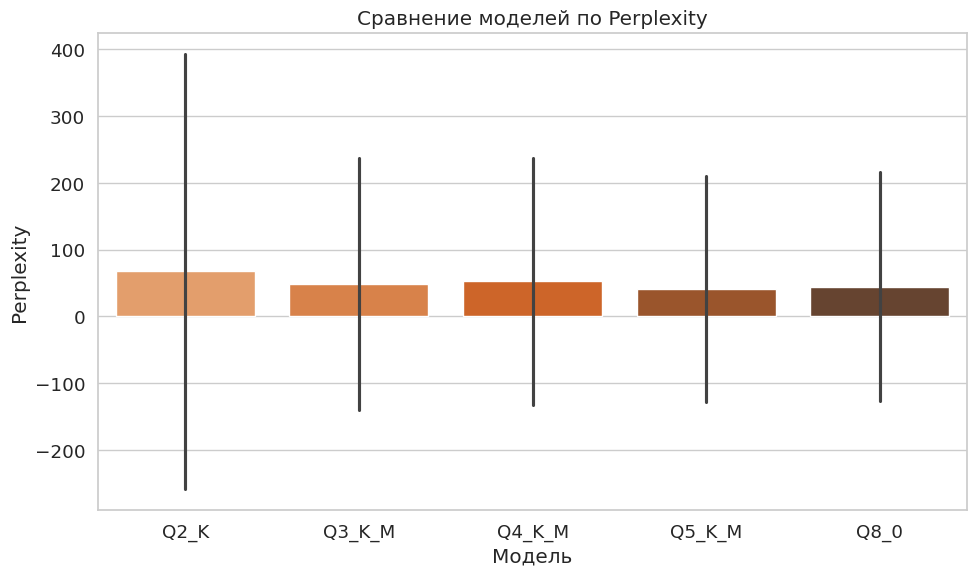

<ipython-input-23-685430899>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x="model", y="sec_per_token", ci="sd", palette="Greens_d")
<ipython-input-23-685430899>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y="sec_per_token", ci="sd", palette="Greens_d")


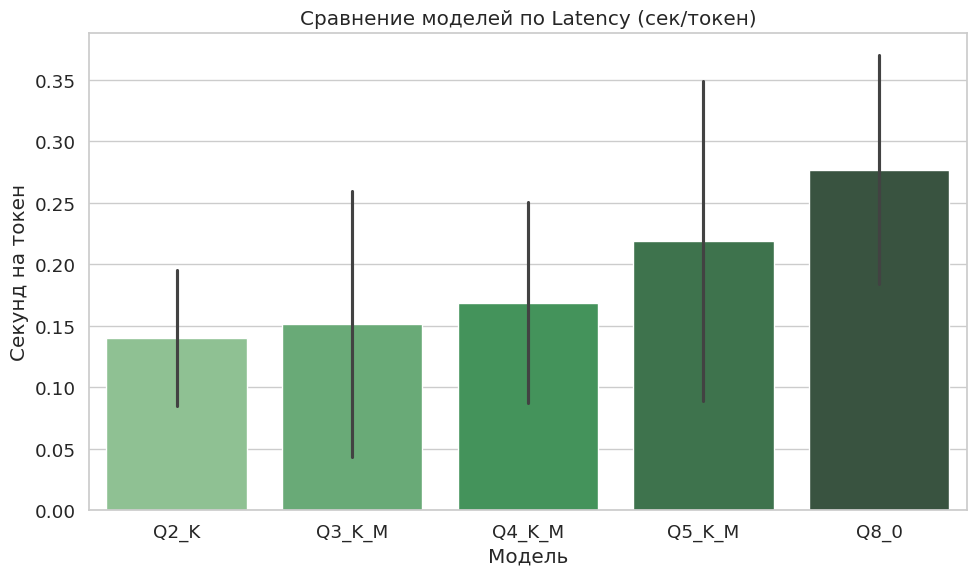

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

plt.figure()
sns.barplot(data=df, x="model", y="perplexity", ci="sd", palette="Oranges_d")
plt.title("Сравнение моделей по Perplexity")
plt.ylabel("Perplexity")
plt.xlabel("Модель")
plt.tight_layout()
plt.show()

plt.figure()
sns.barplot(data=df, x="model", y="sec_per_token", ci="sd", palette="Greens_d")
plt.title("Сравнение моделей по Latency (сек/токен)")
plt.ylabel("Секунд на токен")
plt.xlabel("Модель")
plt.tight_layout()
plt.show()


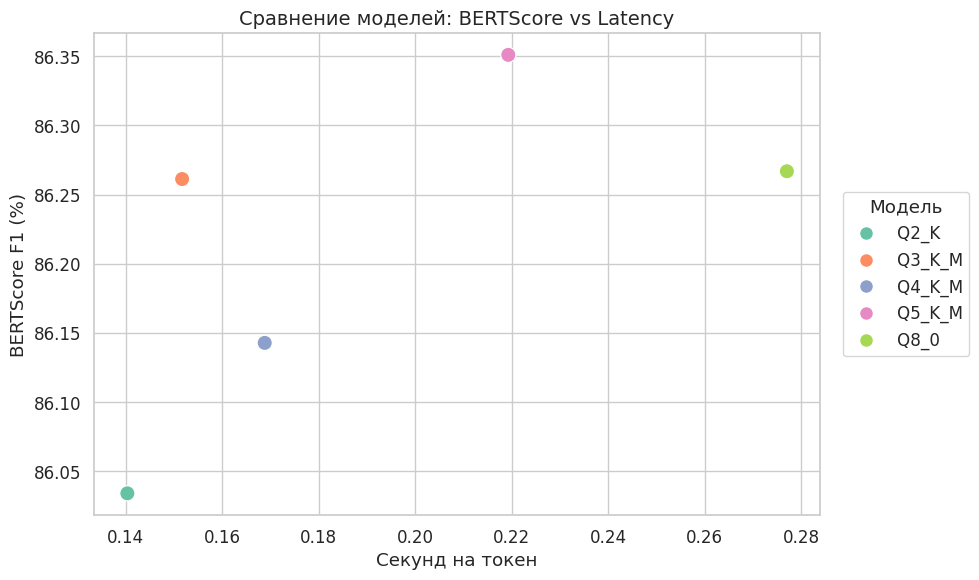

In [ ]:
grouped = df.groupby("model").agg({
    "bertscore_f1": "mean",
    "sec_per_token": "mean"
}).reset_index()

palette = sns.color_palette("Set2", len(grouped))

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=grouped,
    x="sec_per_token",
    y="bertscore_f1",
    hue="model",
    palette=palette,
    s=120,  # размер точек
    legend=False
)

plt.title("Сравнение моделей: BERTScore vs Latency", fontsize=14)
plt.xlabel("Секунд на токен")
plt.ylabel("BERTScore F1 (%)")

from matplotlib.lines import Line2D
model_handles = [
    Line2D([0], [0], marker='o', color='w', label=model,
           markerfacecolor=palette[i], markersize=10)
    for i, model in enumerate(grouped["model"])
]

plt.legend(handles=model_handles, title="Модель", loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
table = df.groupby("model")[[
    "bertscore_f1", "perplexity", "sec_per_token"
]].mean().round(2)

table = table.rename(columns={
    "bertscore_f1": "BERTScore F1 (%)",
    "perplexity": "Perplexity",
    "sec_per_token": "Latency (sec/token)",
})

from IPython.display import display
display(table)


,BERTScore F1 (%),Perplexity,Latency (sec/token)
model,,,
Q2_K,86.03,67.44,0.14
Q3_K_M,86.26,48.14,0.15
Q4_K_M,86.14,52.47,0.17
Q5_K_M,86.35,41.64,0.22
Q8_0,86.27,44.69,0.28


## Prunning

In [ ]:
tokenizer_ppl = AutoTokenizer.from_pretrained("gpt2")
model_ppl = AutoModelForCausalLM.from_pretrained("gpt2").eval()
if torch.cuda.is_available():
    model_ppl = model_ppl.cuda()

NameError: name 'AutoTokenizer' is not defined

In [ ]:
def compute_bleu(reference, prediction):
    reference = [reference.strip().split()]
    prediction = prediction.strip().split()
    smoothing = SmoothingFunction().method1
    return sentence_bleu(reference, prediction, smoothing_function=smoothing) * 100

rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
def compute_rouge_l(reference, prediction):
    scores = rouge.score(reference, prediction)
    return scores["rougeL"].fmeasure * 100

def calculate_perplexity(text):
    # Check if the text is empty or none after converting to string and stripping
    if not isinstance(text, str) or not text.strip():
        return 0 # Return NaN for empty or whitespace-only strings

    inputs = tokenizer_ppl(text, return_tensors="pt")

    # Check if the tokenized input has any tokens
    if inputs["input_ids"].numel() == 0:
        return 0 # Return NaN if tokenization results in an empty sequence

    if torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model_ppl(**inputs, labels=inputs["input_ids"])

    # Ensure the loss is not nan or inf before exponentiating
    if torch.isnan(outputs.loss) or torch.isinf(outputs.loss):
         return 0

    return torch.exp(outputs.loss).item()

In [ ]:
dataset_full = load_dataset("tatsu-lab/alpaca", split="train")
dataset = dataset_full.shuffle(seed=42).select(range(100))

pruned_variants = {
    "original": "meta-llama/Llama-3.2-1B",
    "pruned20": "oopere/pruned20-llama-3.2-1B",
    "pruned40": "oopere/pruned40-llama-3.2-1B",
    "pruned60": "oopere/pruned60-llama-3.2-1B",
}

all_logs = []
df_list = []
proc = psutil.Process()

for variant, model_id in pruned_variants.items():
    print(f"\nEvaluating {variant} ({model_id})...")

    mem_before_model = proc.memory_info().rss / 1024**2

    pipe = pipeline(
        "text-generation",
        model=model_id,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    mem_after_model = proc.memory_info().rss / 1024**2
    model_ram_MB = round(mem_after_model - mem_before_model, 2)
    print(f"Model loaded. RAM usage increased by: {model_ram_MB} MB")

    logs = []

    for item in dataset:
        prompt = item["instruction"]
        reference = item["output"]

        t0 = time.time()
        out = pipe(prompt, max_new_tokens=100)
        response = out[0]["generated_text"][len(prompt):].strip()
        t1 = time.time()

        prompt_tokens = len(tokenizer.encode(prompt))
        response_tokens = len(tokenizer.encode(response))
        total_tokens = prompt_tokens + response_tokens

        total_time = t1 - t0
        sec_per_token = total_time / max(response_tokens, 1)
        throughput = response_tokens / max(total_time, 1e-6)

        logs.append({
            "model": variant,
            "instruction": prompt,
            "reference": reference,
            "prediction": response,
            "gen_time_sec": round(total_time, 2),
            "prompt_tokens": prompt_tokens,
            "response_tokens": response_tokens,
            "total_tokens": total_tokens,
            "sec_per_token": round(sec_per_token, 4),
            "tokens_per_sec": round(throughput, 2),
            "model_load_RAM_MB": model_ram_MB,
        })

    df = pd.DataFrame(logs)
    df_list.append(df)
    all_logs.extend(logs)

final_df = pd.concat(df_list, ignore_index=True)
final_df.to_csv("llama_pruned_comparison.csv", index=False)
print("Comparison complete! Results saved to llama_pruned_comparison.csv")


In [ ]:
to_conc = pd.read_csv("/content/llama_pruned_comparison-2.csv")

In [ ]:
to_conc

In [ ]:
to_conc = to_conc.loc[:, ~to_conc.columns.str.contains('^Unnamed')]

In [ ]:
df = to_conc.copy()

In [ ]:
df

In [ ]:
# df["bleu_score"] = df.apply(lambda row: compute_bleu(str(row["reference"]), str(row["prediction"])), axis=1)
# df["rouge_l_score"] = df.apply(lambda row: compute_rouge_l(str(row["reference"]), str(row["prediction"])), axis=1)
# df["perplexity"] = df["prediction"].apply(calculate_perplexity)
P, R, F1 = bert_score.score(
    df["prediction"].astype(str).tolist(),
    df["reference"].astype(str).tolist(),
    lang="en",
    verbose=True
)
df["bertscore_f1"] = [round(f.item() * 100, 2) for f in F1]

# grouped = df.groupby("model")[[
#     "bertscore_f1", "bleu_score", "rouge_l_score", "perplexity", "sec_per_token", "model_load_RAM_MB"
# ]].mean().round(2).reset_index()

In [ ]:
grouped

In [ ]:
grouped = df.groupby("model")[[
    "bertscore_f1", "sec_per_token"
]].mean().round(2).reset_index()
grouped

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

metrics = ["bertscore_f1", "sec_per_token"]
titles = [
    "BERTScore F1 (%)",
    "Latency (sec/token)"
]

for metric, title in zip(metrics, titles):
    plt.figure()
    ax = sns.barplot(data=grouped, x="model", y=metric, palette="viridis")
    ax.set_title(f"{title} by Model")
    ax.set_ylabel(title)
    ax.set_xlabel("Model")
    for index, value in enumerate(grouped[metric]):
        ax.text(index, value + 0.5, f"{value:.2f}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

table_deepseek = df.groupby("model")[[
    "bertscore_f1", "sec_per_token"
]].mean().round(2)

table_deepseek = table_deepseek.rename(columns={
    "bertscore_f1": "BERTScore F1 (%)",
    "sec_per_token": "Latency (sec/token)",
})

display(table_deepseek)

## Distilation

In [ ]:
# #Experiment 1 - неуспешный
# dataset_full = load_dataset("tatsu-lab/alpaca", split="train")
# dataset = dataset_full.shuffle(seed=42).select(range(1))

# variants = {
#     "DeepSeek-R1-Distill-Llama-8B": "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
#     "Llama-3.1-8B-Instruct": "meta-llama/Llama-3.1-8B-Instruct",
# }

In [ ]:
# #Experiment 2 - неуспешный
# pruned_variants = {
#     "DeepSeek-8B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
#     "Qwen2.5-Math-7B": "Qwen/Qwen2.5-Math-7B",
# }

In [ ]:
dataset_full = load_dataset("tatsu-lab/alpaca", split="train")
dataset = dataset_full.shuffle(seed=42).select(range(100, 601))

pruned_variants = {
    "DeepSeek-1.5B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "Qwen2.5-Math-7B": "Qwen/Qwen2.5-Math-1.5B",
}

all_logs = []
df_list = []
proc = psutil.Process()

for variant, model_id in pruned_variants.items():
    print(f"\nEvaluating {variant} ({model_id})...")

    mem_before_model = proc.memory_info().rss / 1024**2

    pipe = pipeline(
        "text-generation",
        model=model_id,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    mem_after_model = proc.memory_info().rss / 1024**2
    model_ram_MB = round(mem_after_model - mem_before_model, 2)
    print(f"Model loaded. RAM usage increased by: {model_ram_MB} MB")

    logs = []

    for item in dataset:
        prompt = item["instruction"]
        reference = item["output"]

        t0 = time.time()
        out = pipe(prompt, max_new_tokens=100)
        response = out[0]["generated_text"][len(prompt):].strip()
        t1 = time.time()

        prompt_tokens = len(tokenizer.encode(prompt))
        response_tokens = len(tokenizer.encode(response))
        total_tokens = prompt_tokens + response_tokens

        total_time = t1 - t0
        sec_per_token = total_time / max(response_tokens, 1)
        throughput = response_tokens / max(total_time, 1e-6)

        logs.append({
            "model": variant,
            "instruction": prompt,
            "reference": reference,
            "prediction": response,
            "gen_time_sec": round(total_time, 2),
            "prompt_tokens": prompt_tokens,
            "response_tokens": response_tokens,
            "total_tokens": total_tokens,
            "sec_per_token": round(sec_per_token, 4),
            "tokens_per_sec": round(throughput, 2),
            "model_load_RAM_MB": model_ram_MB,
        })

    df = pd.DataFrame(logs)
    df_list.append(df)
    all_logs.extend(logs)

final_df = pd.concat(df_list, ignore_index=True)
final_df.to_csv("llama_pruned_comparison.csv", index=False)
print("Comparison complete! Results saved to llama_pruned_comparison.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

data/train-00000-of-00001-a09b74b3ef9c3b(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]


Evaluating DeepSeek-1.5B (deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B)...


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda:0


Model loaded. RAM usage increased by: 245.32 MB


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Evaluating Qwen2.5-Math-7B (Qwen/Qwen2.5-Math-1.5B)...


config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.32k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda:0


Model loaded. RAM usage increased by: 603.41 MB
Comparison complete! Results saved to llama_pruned_comparison.csv


In [ ]:
final_df['model'] = final_df['model'].replace('Qwen2.5-Math-7B', 'Qwen2.5-Math-1.5B')


In [ ]:
final_df

,model,instruction,reference,prediction,gen_time_sec,prompt_tokens,response_tokens,total_tokens,sec_per_token,tokens_per_sec,model_load_RAM_MB
0,DeepSeek-1.5B,What is a disadvantage of using a deep learnin...,A disadvantage of using a deep learning networ...,A) It is not reliable for real-time applicatio...,5.19,16,100,116,0.0519,19.27,245.32
1,DeepSeek-1.5B,Generate a memorable metaphor,Life is like a rollercoaster - it has its ups ...,"for a situation where the world is in chaos, a...",3.83,5,101,106,0.0379,26.35,245.32
2,DeepSeek-1.5B,"Analyze the character of Daisy Buchanan, in Th...","Daisy Buchanan, in The Great Gatsby, symbolize...",", and evaluate her role in the story. Use evid...",3.79,14,101,115,0.0375,26.63,245.32
3,DeepSeek-1.5B,Explain why English is a difficult language to...,English is a difficult language to learn becau...,"(Answer using examples and...\n\nTo start, exp...",3.77,12,101,113,0.0373,26.79,245.32
4,DeepSeek-1.5B,What changes can be made to make the following...,The most fortunate event occurred occasionally.,"""What is the probability that the number of......",3.77,15,100,115,0.0377,26.51,245.32
...,...,...,...,...,...,...,...,...,...,...,...
997,Qwen2.5-Math-1.5B,Create a command to make the assistant talk wi...,"""Talk in British accent""",Create a command to make the assistant talk wi...,3.79,13,100,113,0.0379,26.42,603.41
998,Qwen2.5-Math-1.5B,Design an experiment to evaluate the efficacy ...,A good way to evaluate the efficacy of the pro...,Use the following variables:\n\n* Treatment gr...,1.90,12,49,61,0.0388,25.80,603.41
999,Qwen2.5-Math-1.5B,You are provided with two paragraphs. Count th...,4,"The first paragraph contains 10 adjectives, an...",0.84,18,21,39,0.0398,25.10,603.41
1000,Qwen2.5-Math-1.5B,What is the probability that it will rain tomo...,It is not possible to give an exact probabilit...,It has rained every day this past week. I am t...,3.78,10,100,110,0.0378,26.47,603.41


In [ ]:
# dataset = load_dataset("gsm8k", "main")
# sample = dataset["test"].select(range(1))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
# #device = "cpu"
# proc = psutil.Process()

# variants = {
#     "DeepSeek-1.5B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
#     "Qwen2.5-Math-7B": "Qwen/Qwen2.5-Math-1.5B",
# }

# all_logs = []
# df_list = []
# model_inputs = []

# for variant, model_id in variants.items():
#     print(f"\nEvaluating {variant}...")

#     mem_before_model = proc.memory_info().rss / 1024**2

#     tokenizer = AutoTokenizer.from_pretrained(model_id)
#     model = AutoModelForCausalLM.from_pretrained(
#         model_id,
#         torch_dtype=torch.float16 if device == "cuda" else torch.float32
#     )
#     model.to(device)
#     model.eval()

#     mem_after_model = proc.memory_info().rss / 1024**2
#     model_ram_MB = round(mem_after_model - mem_before_model, 2)
#     print(f"Model loaded. RAM usage increased by: {model_ram_MB} MB")

#     model_inputs.append({
#         "model": variant,
#         "model_load_RAM_MB": model_ram_MB
#     })

#     logs = []

#     for item in sample:
#         question = item["question"]
#         reference = item["answer"]

#         prompt = f'''Q: Janet’s ducks lay 16 eggs per day. She eats three and gives four to her neighbor. How many eggs does she have left to sell each day?
#                   A: Show your solution step by step using calculator-style annotations (like 16-3-4=<<16-3-4=9>>9), and write the final answer after four hash marks (####) on a new line.
#                 '''

#         inputs = tokenizer(prompt, return_tensors="pt").to(device)

#         t0 = time.time()
#         with torch.no_grad():
#             outputs = model.generate(**inputs, max_new_tokens=100)
#         t1 = time.time()

#         response = tokenizer.decode(outputs[0], skip_special_tokens=True)
#         response_text = response.replace(prompt, "").strip()

#         prompt_tokens = len(tokenizer.encode(prompt))
#         response_tokens = len(tokenizer.encode(response_text))
#         total_tokens = prompt_tokens + response_tokens

#         total_time = t1 - t0
#         sec_per_token = total_time / max(response_tokens, 1)
#         throughput = response_tokens / max(total_time, 1e-6)

#         logs.append({
#             "model": variant,
#             "question": question,
#             "reference": reference,
#             "prediction": response_text,
#             "gen_time_sec": round(total_time, 2),
#             "prompt_tokens": prompt_tokens,
#             "response_tokens": response_tokens,
#             "total_tokens": total_tokens,
#             "sec_per_token": round(sec_per_token, 4),
#             "tokens_per_sec": round(throughput, 2),
#         })

#     df = pd.DataFrame(logs)
#     df_list.append(df)
#     all_logs.extend(logs)

# final_df = pd.concat(df_list, ignore_index=True)


Evaluating DeepSeek-1.5B...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Model loaded. RAM usage increased by: 7.28 MB

Evaluating Qwen2.5-Math-7B...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Model loaded. RAM usage increased by: 653.94 MB


In [ ]:
final_df

,model,instruction,reference,prediction,gen_time_sec,prompt_tokens,response_tokens,total_tokens,sec_per_token,tokens_per_sec,model_load_RAM_MB
0,DeepSeek-1.5B,What would be the best type of exercise for a ...,"For someone with arthritis, the best type of e...","I have arthritis, and I'm trying to lose weigh...",3.73,16,101,117,0.0370,27.06,16.18
1,DeepSeek-1.5B,Calculate the atomic mass for lithium.,The atomic mass for lithium is 6.941 u (units)...,If the atomic mass is calculated using the for...,3.63,8,101,109,0.0359,27.82,16.18
2,DeepSeek-1.5B,Convert the following binary code to ASCII cha...,The ASCII characters for the binary code is: w...,Assume that the code is a proper binary repres...,3.65,10,102,112,0.0358,27.95,16.18
3,DeepSeek-1.5B,Take this sentence and make it more descriptiv...,"She was trembling with fear, her heart racing ...",She was trembling. She was about to jump. She ...,3.70,14,101,115,0.0366,27.32,16.18
4,DeepSeek-1.5B,Brainstorm 3 possible ideas to promote the fol...,1. Offer a free trial for a limited time.\n2. ...,": ""A real-time, multi-threaded chatbot with 10...",3.65,12,101,113,0.0361,27.69,16.18
...,...,...,...,...,...,...,...,...,...,...,...
195,Qwen2.5-Math-7B,Come up with 5 new ideas for a product design.,- A product that combines headphones and a Blu...,"In each of your designs, identify the product,...",3.66,12,100,112,0.0366,27.29,0.34
196,Qwen2.5-Math-7B,"Provide a context to this sentence: ""He sugges...","In the lecture, Professor Smith was discussing...","The sentence ""He suggested the theory"" provide...",2.48,13,67,80,0.0369,27.07,0.34
197,Qwen2.5-Math-7B,Describe the main differences between a voice ...,A voice assistant can understand spoken comman...,Voice assistants are designed to mimic human v...,1.40,16,38,54,0.0369,27.14,0.34
198,Qwen2.5-Math-7B,Edit the following sentence to make it more fo...,I have been the unfortunate victim of a stolen...,The revised sentence is more formal and struct...,1.28,23,33,56,0.0388,25.77,0.34


In [ ]:
final_df.to_csv("deepseek_results.csv")

In [ ]:
final_df = pd.read_csv("/content/deepseek_results copy.csv")

In [ ]:
df = final_df.copy()

In [ ]:
def compute_bleu(reference, prediction):
    reference = [reference.strip().split()]
    prediction = prediction.strip().split()
    smoothing = SmoothingFunction().method1
    return sentence_bleu(reference, prediction, smoothing_function=smoothing) * 100  # в %

rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_rouge_l(reference, prediction):
    scores = rouge.score(reference, prediction)
    return scores["rougeL"].fmeasure * 100  # в %

df["bleu_score"] = df.apply(lambda row: compute_bleu(str(row["reference"]), str(row["prediction"])), axis=1)
df["rouge_l_score"] = df.apply(lambda row: compute_rouge_l(str(row["reference"]), str(row["prediction"])), axis=1)

P, R, F1 = bert_score(df["prediction"].astype(str).tolist(), df["reference"].astype(str).tolist(), lang="en", verbose=True)

df["bertscore_f1"] = [round(f.item() * 100, 2) for f in F1]

# df["perplexity"] = df["prediction"].astype(str).apply(calculate_perplexity)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/24 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 13.49 seconds, 74.27 sentences/sec


/tmp/ipython-input-28-3687664280.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped_deepseek, x="model", y=metric, palette="viridis")


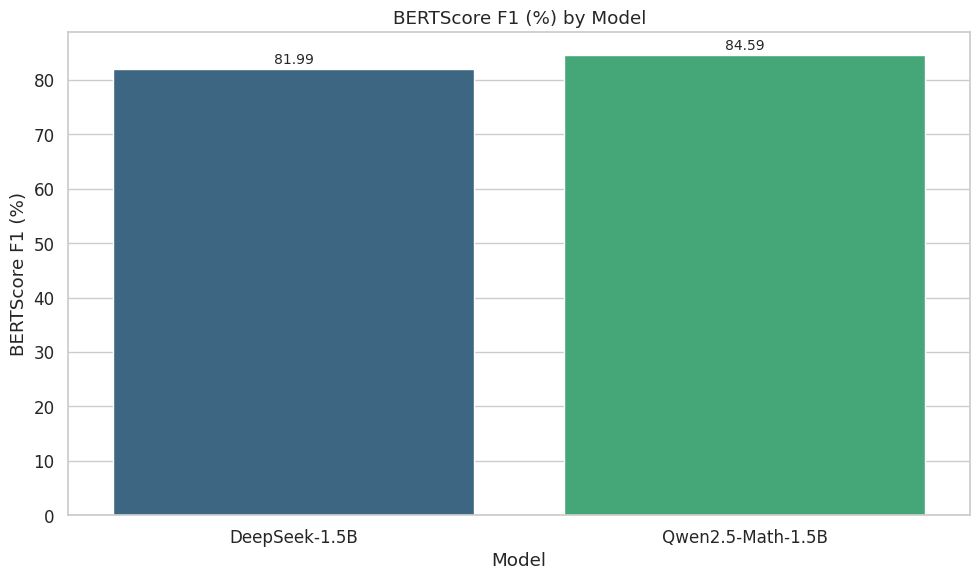

/tmp/ipython-input-28-3687664280.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped_deepseek, x="model", y=metric, palette="viridis")


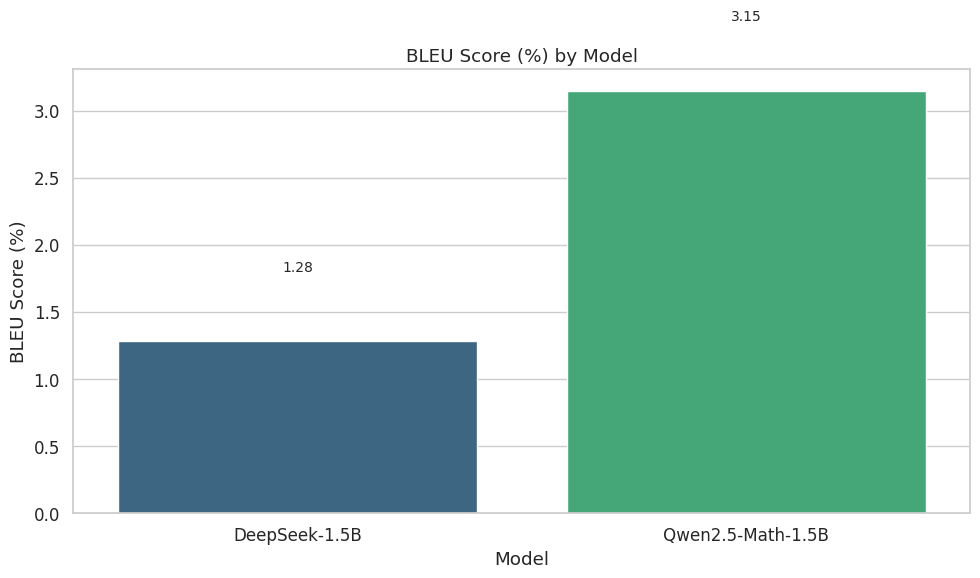

/tmp/ipython-input-28-3687664280.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped_deepseek, x="model", y=metric, palette="viridis")


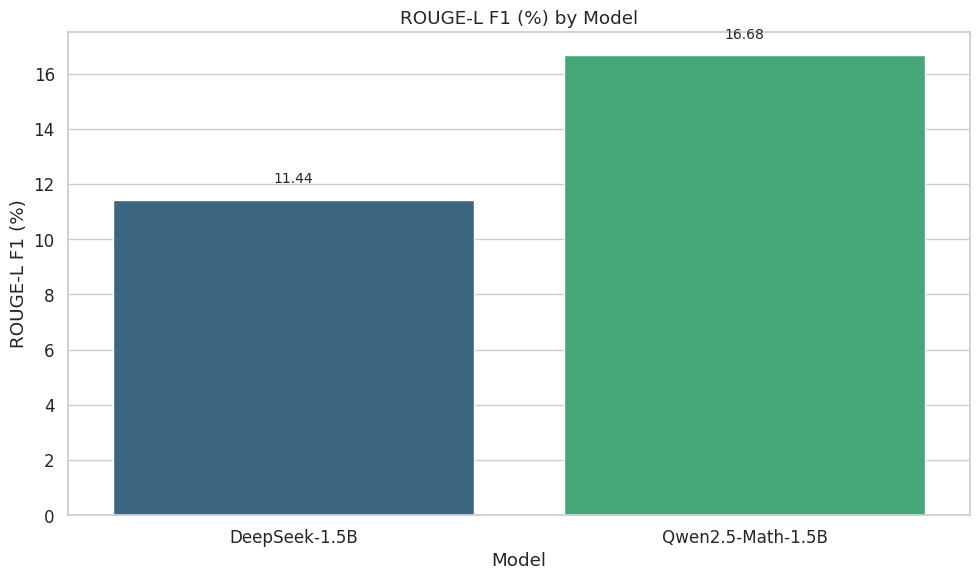

/tmp/ipython-input-28-3687664280.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped_deepseek, x="model", y=metric, palette="viridis")
/tmp/ipython-input-28-3687664280.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


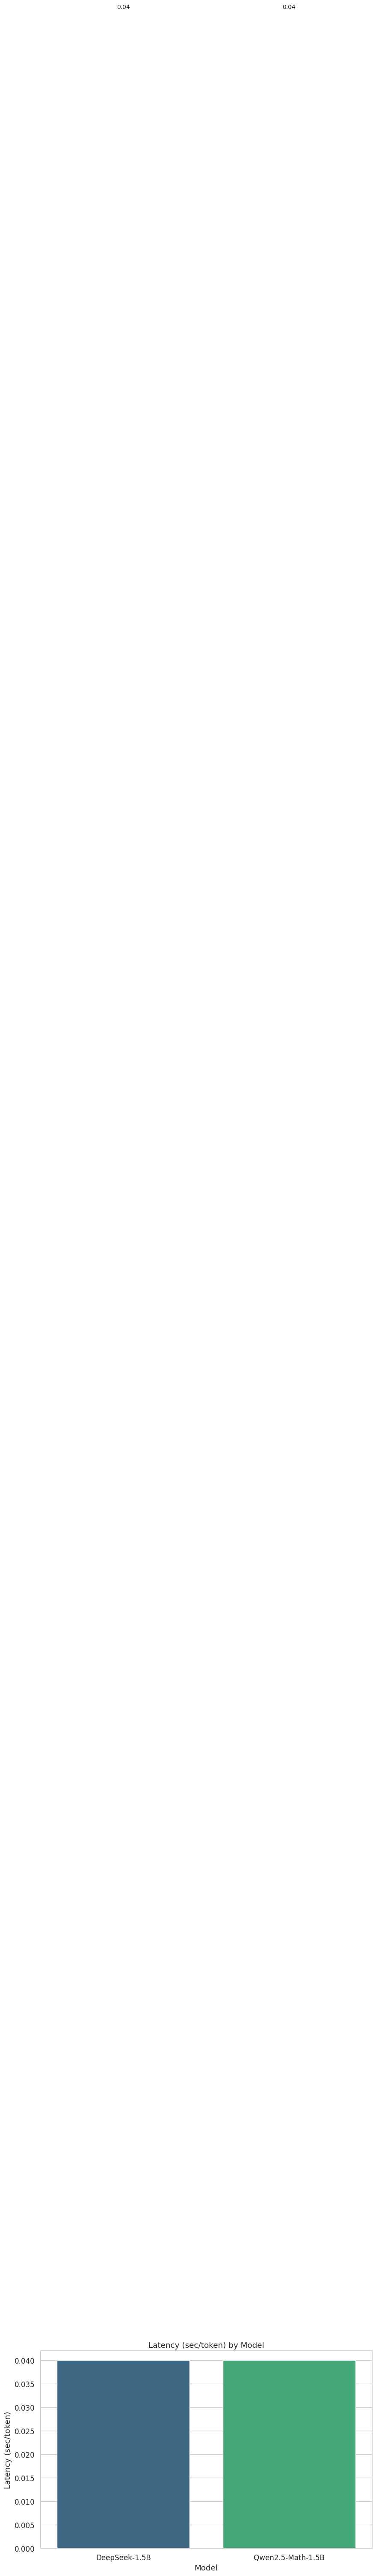

,BERTScore F1 (%),Latency (sec/token)
model,,
DeepSeek-1.5B,81.99,0.04
Qwen2.5-Math-1.5B,84.59,0.04


In [ ]:
grouped_deepseek = df.groupby("model")[[
    "bertscore_f1", "bleu_score", "rouge_l_score", "sec_per_token"
]].mean().round(2).reset_index()
grouped_deepseek

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

metrics = ["bertscore_f1", "bleu_score", "rouge_l_score", "sec_per_token"]
titles = [
    "BERTScore F1 (%)",
    "BLEU Score (%)",
    "ROUGE-L F1 (%)",
    "Latency (sec/token)"
]

for metric, title in zip(metrics, titles):
    plt.figure()
    ax = sns.barplot(data=grouped_deepseek, x="model", y=metric, palette="viridis")
    ax.set_title(f"{title} by Model")
    ax.set_ylabel(title)
    ax.set_xlabel("Model")
    for index, value in enumerate(grouped_deepseek[metric]):
        ax.text(index, value + 0.5, f"{value:.2f}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

table_deepseek = df.groupby("model")[[
    "bertscore_f1", "sec_per_token"
]].mean().round(2)

table_deepseek = table_deepseek.rename(columns={
    "bertscore_f1": "BERTScore F1 (%)",
    "sec_per_token": "Latency (sec/token)",
})

display(table_deepseek)


In [ ]:
df

,model,instruction,reference,prediction,gen_time_sec,prompt_tokens,response_tokens,total_tokens,sec_per_token,tokens_per_sec,model_load_RAM_MB,bleu_score,rouge_l_score,bertscore_f1
0,DeepSeek-1.5B,What is a disadvantage of using a deep learnin...,A disadvantage of using a deep learning networ...,"Please reason step by step, and explain...\nOk...",4.37,16,101,117,0.0432,23.12,255.37,9.117451,23.611111,86.40
1,DeepSeek-1.5B,Generate a memorable metaphor,Life is like a rollercoaster - it has its ups ...,"for the phrase ""tread the path of the unknown....",3.75,5,101,106,0.0371,26.95,255.37,0.283705,9.615385,81.38
2,DeepSeek-1.5B,"Analyze the character of Daisy Buchanan, in Th...","Daisy Buchanan, in The Great Gatsby, symbolize...",", through the lens of a reader's internal mono...",3.71,14,101,115,0.0368,27.20,255.37,1.848776,18.285714,83.98
3,DeepSeek-1.5B,Explain why English is a difficult language to...,English is a difficult language to learn becau...,Include the following: 1. The phonetics of En...,3.74,12,101,113,0.0370,27.04,255.37,0.498111,14.864865,82.97
4,DeepSeek-1.5B,What changes can be made to make the following...,The most fortunate event occurred occasionally.,"The phrase is: ""A person is happy if they are ...",3.74,15,101,116,0.0370,27.02,255.37,0.203249,2.105263,82.20
5,DeepSeek-1.5B,Generate a list of 5 items that I need to pack...,1. Clothes\n2. Personal care items\n3. Necessa...,Each item must be labeled with the category it...,3.71,17,101,118,0.0367,27.22,255.37,0.302012,6.666667,83.09
6,DeepSeek-1.5B,Write a classification model to classify movie...,A classification model can be built on movie r...,"You can use any approach, but the goal is to a...",3.71,16,101,117,0.0368,27.20,255.37,8.335675,22.222222,85.94
7,DeepSeek-1.5B,Compress the following text using Lempel-Ziv-W...,0A0C0A0D0E0M0I00P0R00G0R0A00M,".\n\nThe input is a string of bytes, each byte...",3.77,20,101,121,0.0373,26.79,255.37,0.000000,0.000000,76.29
8,DeepSeek-1.5B,"Given the input, state the relationship betwee...",PersonX and PersonY are both professionals in ...,Is it... (1) similar... (2) identical... (3) d...,3.92,13,101,114,0.0388,25.77,255.37,0.000000,0.000000,76.03
9,DeepSeek-1.5B,Generate a list of five positive attitudes.,1. Optimism\n2. Self-confidence\n3. Gratitude\...,"Then, using each of these five, construct a li...",3.68,9,101,110,0.0364,27.44,255.37,0.000000,0.000000,82.31


In [ ]:
dataset = load_dataset("euclaise/writingprompts", split="train[:20]")

models = {
    "DeepSeek-1.5B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "Qwen2.5-Math-1.5B": "Qwen/Qwen2.5-Math-1.5B",
}

gen_kwargs = {"max_new_tokens": 100, "temperature": 0.8, "top_p": 0.95, "do_sample": True}

all_logs = []
df_list = []
proc = psutil.Process()

for name, model_id in models.items():
    print(f"\nEvaluating {name} ({model_id})...")

    mem_before_model = proc.memory_info().rss / 1024**2

    pipe = pipeline("text-generation", model=model_id, device_map="auto", torch_dtype="auto")
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    mem_after_model = proc.memory_info().rss / 1024**2
    model_ram_MB = round(mem_after_model - mem_before_model, 2)
    print(f"Model loaded. RAM usage increased by: {model_ram_MB} MB")

    logs = []

    for item in dataset:
        prompt = item["prompt"]
        reference = item["story"]

        t0 = time.time()
        out = pipe(prompt, **gen_kwargs)
        t1 = time.time()

        full_generated = out[0]["generated_text"]
        response = full_generated[len(prompt):].strip()

        prompt_tokens = len(tokenizer.encode(prompt))
        response_tokens = len(tokenizer.encode(response))
        total_tokens = prompt_tokens + response_tokens

        total_time = t1 - t0
        sec_per_token = total_time / max(response_tokens, 1)
        throughput = response_tokens / max(total_time, 1e-6)

        try:
            _, _, F1 = bertscore([response], [reference], lang="en", verbose=False)
            bert_f1 = round(F1[0].item(), 4)
        except:
            bert_f1 = None

        logs.append({
            "model": name,
            "prompt": prompt,
            "reference": reference,
            "prediction": response,
            "gen_time_sec": round(total_time, 2),
            "prompt_tokens": prompt_tokens,
            "response_tokens": response_tokens,
            "total_tokens": total_tokens,
            "sec_per_token": round(sec_per_token, 4),
            "tokens_per_sec": round(throughput, 2),
            "model_load_RAM_MB": model_ram_MB,
            "bertscore_f1": bert_f1
        })

    df = pd.DataFrame(logs)
    df_list.append(df)
    all_logs.extend(logs)

final_df = pd.concat(df_list, ignore_index=True)
final_df.to_csv("openended_writingprompts_comparison.csv", index=False)


Evaluating DeepSeek-1.5B (deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B)...


Device set to use cuda:0


Model loaded. RAM usage increased by: 4.95 MB


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho


Evaluating Qwen2.5-Math-1.5B (Qwen/Qwen2.5-Math-1.5B)...


Device set to use cuda:0


Model loaded. RAM usage increased by: 12.11 MB


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

In [ ]:
df = final_df.copy()

In [ ]:
def compute_bleu(reference, prediction):
    reference = [reference.strip().split()]
    prediction = prediction.strip().split()
    smoothing = SmoothingFunction().method1
    return sentence_bleu(reference, prediction, smoothing_function=smoothing) * 100  # в %

rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_rouge_l(reference, prediction):
    scores = rouge.score(reference, prediction)
    return scores["rougeL"].fmeasure * 100  # в %

df["bleu_score"] = df.apply(lambda row: compute_bleu(str(row["reference"]), str(row["prediction"])), axis=1)
df["rouge_l_score"] = df.apply(lambda row: compute_rouge_l(str(row["reference"]), str(row["prediction"])), axis=1)

P, R, F1 = bert_score(df["prediction"].astype(str).tolist(), df["reference"].astype(str).tolist(), lang="en", verbose=True)

df["bertscore_f1"] = [round(f.item() * 100, 2) for f in F1]

# df["perplexity"] = df["prediction"].astype(str).apply(calculate_perplexity)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.17 seconds, 18.46 sentences/sec


/tmp/ipython-input-38-3889438897.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped_deepseek, x="model", y=metric, palette="viridis")


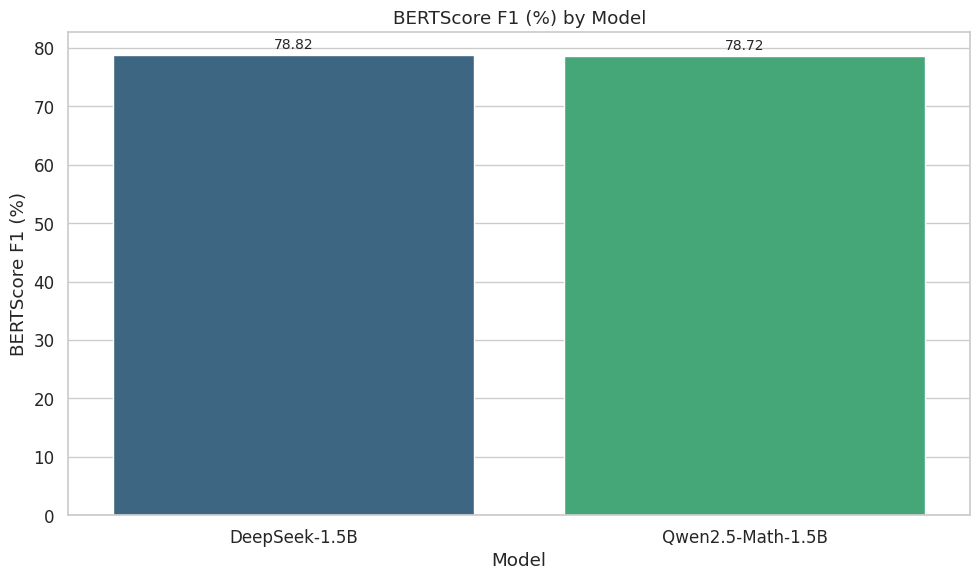

/tmp/ipython-input-38-3889438897.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped_deepseek, x="model", y=metric, palette="viridis")
/tmp/ipython-input-38-3889438897.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


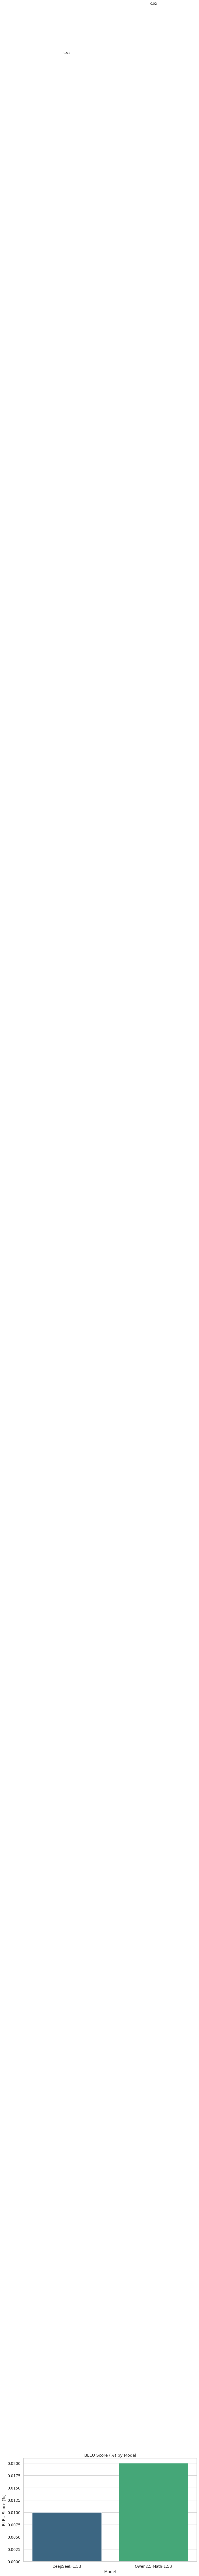

/tmp/ipython-input-38-3889438897.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped_deepseek, x="model", y=metric, palette="viridis")


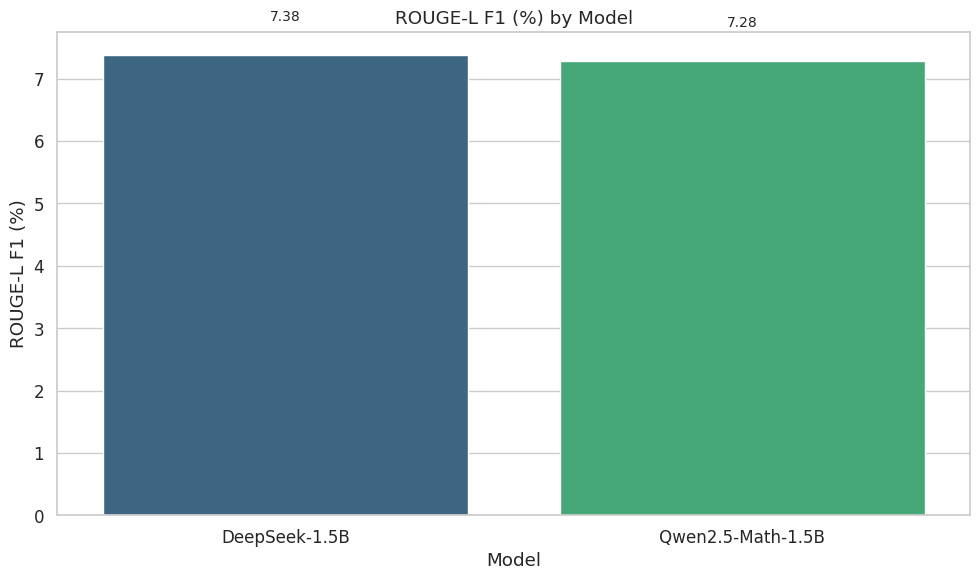

/tmp/ipython-input-38-3889438897.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped_deepseek, x="model", y=metric, palette="viridis")
/tmp/ipython-input-38-3889438897.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


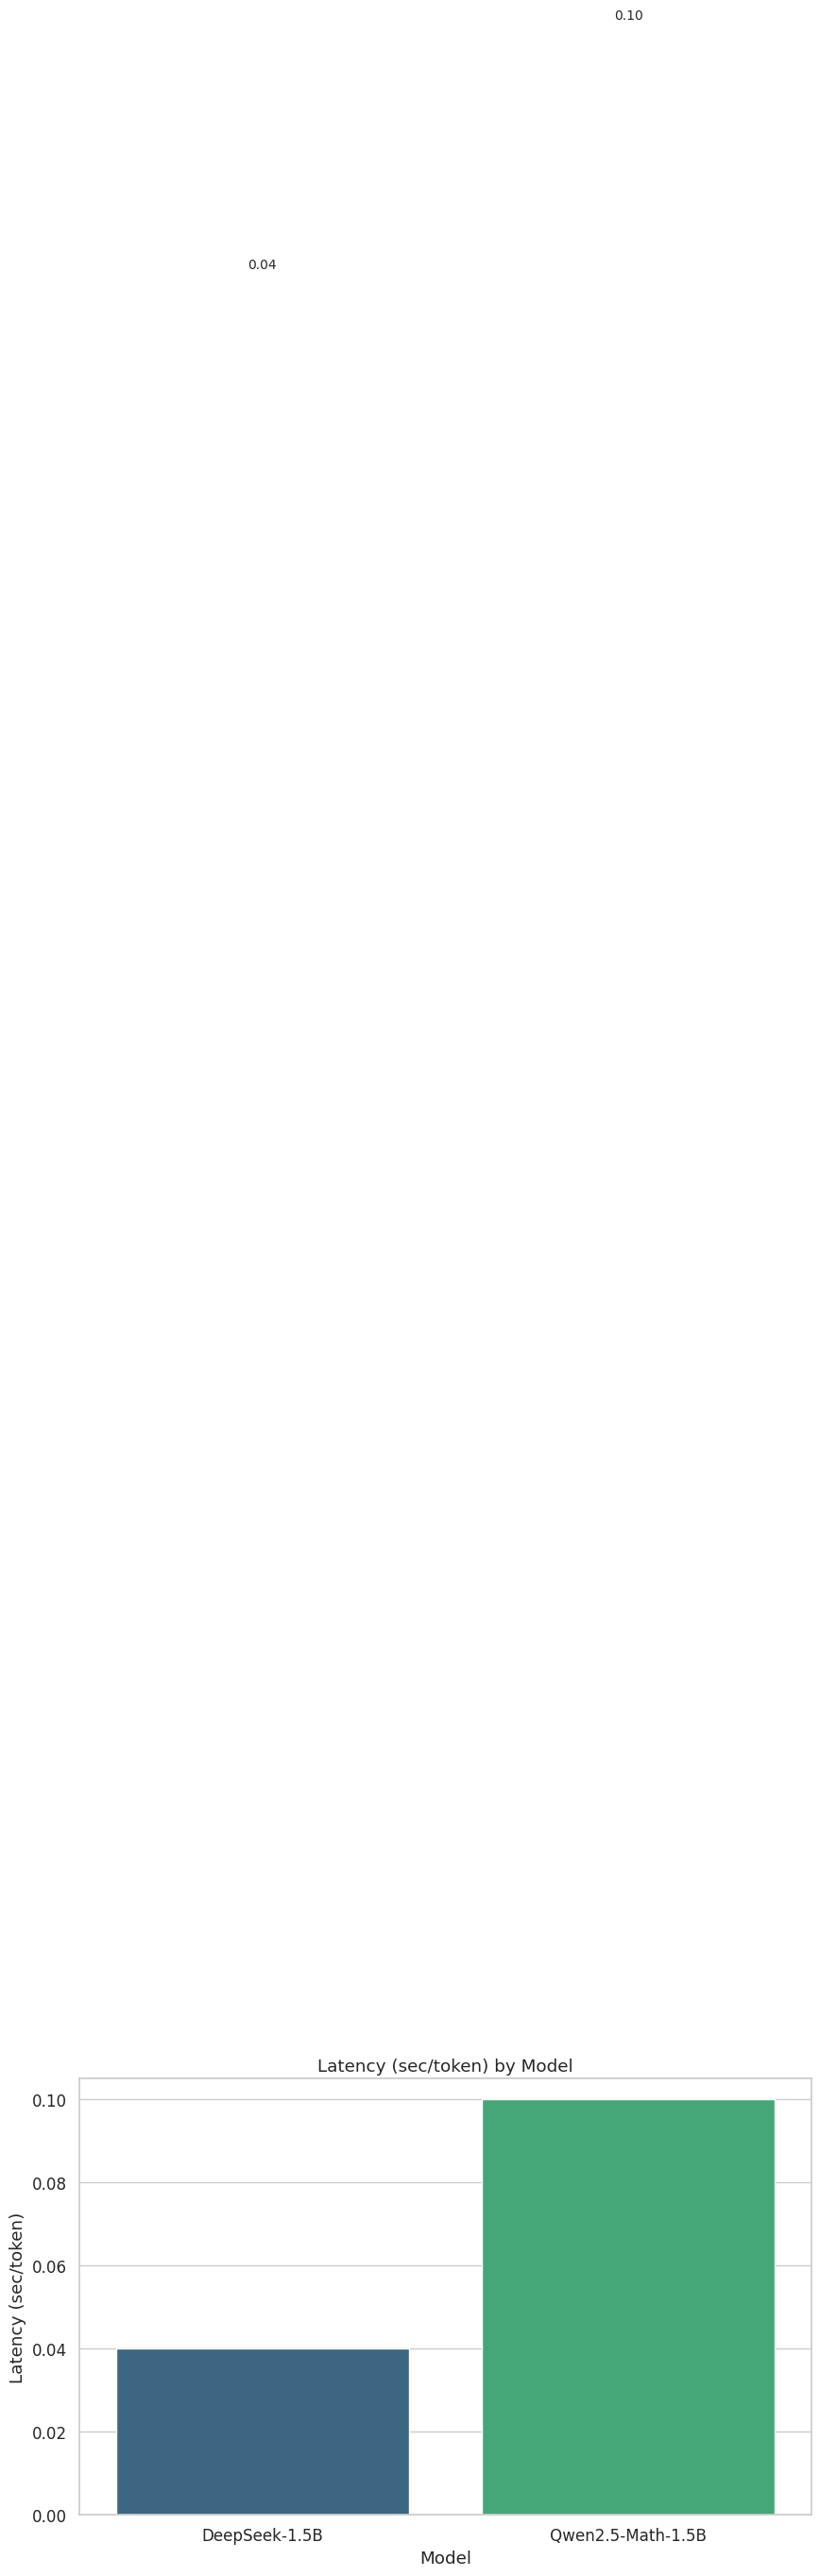

,BERTScore F1 (%),Latency (sec/token)
model,,
DeepSeek-1.5B,78.82,0.04
Qwen2.5-Math-1.5B,78.72,0.10


In [ ]:
grouped_deepseek = df.groupby("model")[[
    "bertscore_f1", "bleu_score", "rouge_l_score", "sec_per_token"
]].mean().round(2).reset_index()
grouped_deepseek

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

metrics = ["bertscore_f1", "bleu_score", "rouge_l_score", "sec_per_token"]
titles = [
    "BERTScore F1 (%)",
    "BLEU Score (%)",
    "ROUGE-L F1 (%)",
    "Latency (sec/token)"
]

for metric, title in zip(metrics, titles):
    plt.figure()
    ax = sns.barplot(data=grouped_deepseek, x="model", y=metric, palette="viridis")
    ax.set_title(f"{title} by Model")
    ax.set_ylabel(title)
    ax.set_xlabel("Model")
    for index, value in enumerate(grouped_deepseek[metric]):
        ax.text(index, value + 0.5, f"{value:.2f}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

table_deepseek = df.groupby("model")[[
    "bertscore_f1", "sec_per_token"
]].mean().round(2)

table_deepseek = table_deepseek.rename(columns={
    "bertscore_f1": "BERTScore F1 (%)",
    "sec_per_token": "Latency (sec/token)",
})

display(table_deepseek)

## Visualization and weight calculation

In [ ]:
repo_id = "TheBloke/Mistral-7B-Instruct-v0.1-GGUF"

Q_variants = {
    "Q2_K": "mistral-7b-instruct-v0.1.Q2_K.gguf",
    "Q3_K_M": "mistral-7b-instruct-v0.1.Q3_K_M.gguf",
    "Q4_K_M": "mistral-7b-instruct-v0.1.Q4_K_M.gguf",
    "Q5_K_M": "mistral-7b-instruct-v0.1.Q5_K_S.gguf",
    "Q8_0": "mistral-7b-instruct-v0.1.Q8_0.gguf"
}

model_data = []
proc = psutil.Process()

for name, filename in Q_variants.items():
    print(f"Uploading {name}...")
    gc.collect()
    mem_before = proc.memory_info().rss / 1024 ** 2
    t0 = time.time()
    llm = Llama.from_pretrained(
        repo_id=repo_id,
        filename=filename,
    )
    t1 = time.time()
    mem_after = proc.memory_info().rss / 1024 ** 2
    del llm
    gc.collect()
    model_data.append({
        "model_name": name,
        "uploading_time_sec": round(t1 - t0, 2),
        "ram_used_MB": round(mem_after - mem_before, 2)
    })

df = pd.DataFrame(model_data)
print(df)
df.to_csv("q_models_clean_upload_stats.csv", index=False)


llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.1-GGUF/snapshots/731a9fc8f06f5f5e2db8a0cf9d256197eb6e05d1/./mistral-7b-instruct-v0.1.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - 

Uploading Q4_K_M...


load: control token:      1 '<s>' is not marked as EOG
load: special_eos_id is not in special_eog_ids - the tokenizer config may be incorrect
load: special tokens cache size = 3
load: token to piece cache size = 0.1637 MB
print_info: arch             = llama
print_info: vocab_only       = 0
print_info: n_ctx_train      = 32768
print_info: n_embd           = 4096
print_info: n_layer          = 32
print_info: n_head           = 32
print_info: n_head_kv        = 8
print_info: n_rot            = 128
print_info: n_swa            = 0
print_info: n_swa_pattern    = 1
print_info: n_embd_head_k    = 128
print_info: n_embd_head_v    = 128
print_info: n_gqa            = 4
print_info: n_embd_k_gqa     = 1024
print_info: n_embd_v_gqa     = 1024
print_info: f_norm_eps       = 0.0e+00
print_info: f_norm_rms_eps   = 1.0e-05
print_info: f_clamp_kqv      = 0.0e+00
print_info: f_max_alibi_bias = 0.0e+00
print_info: f_logit_scale    = 0.0e+00
print_info: f_attn_scale     = 0.0e+00
print_info: n_ff        

  model_name  uploading_time_sec  ram_used_MB
0     Q4_K_M                7.79      7433.81


In [ ]:
hf_models = {
    "DeepSeek-1.5B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "Qwen2.5-Math-7B": "Qwen/Qwen2.5-Math-1.5B",
    "original": "meta-llama/Llama-3.2-1B",
    "pruned20": "oopere/pruned20-llama-3.2-1B",
    "pruned40": "oopere/pruned40-llama-3.2-1B",
    "pruned60": "oopere/pruned60-llama-3.2-1B",
}

proc = psutil.Process()
model_data = []

for name, model_id in hf_models.items():
    print(f"Uploading {name}...")
    gc.collect()
    mem_before = proc.memory_info().rss / 1024 ** 2
    t0 = time.time()
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(model_id)
    model.eval()
    t1 = time.time()
    mem_after = proc.memory_info().rss / 1024 ** 2
    del model
    del tokenizer
    gc.collect()
    model_data.append({
        "model_name": name,
        "uploading_time_sec": round(t1 - t0, 2),
        "ram_used_MB": round(mem_after - mem_before, 2)
    })

df = pd.DataFrame(model_data)
print(df)
df.to_csv("hf_models_clean_upload_stats.csv", index=False)


Uploading DeepSeek-1.5B...


tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Uploading Qwen2.5-Math-7B...


tokenizer_config.json:   0%|          | 0.00/7.32k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Uploading original...


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Uploading pruned20...


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Uploading pruned40...


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Uploading pruned60...


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

        model_name  uploading_time_sec  ram_used_MB
0    DeepSeek-1.5B               66.46      7401.38
1  Qwen2.5-Math-7B              200.22      6328.17
2         original              182.54      4016.76
3         pruned20               47.98      3684.38
4         pruned40               47.95      2685.61
5         pruned60               33.29      1276.57


In [ ]:
q_models_df = pd.read_csv("q_models_clean_upload_stats.csv")
hf_models_df = pd.read_csv("hf_models_clean_upload_stats.csv")

combined_df = pd.concat([q_models_df, hf_models_df], ignore_index=True)

combined_df["model_name"] = combined_df["model_name"].replace("original", "Llama-3.2-1B")

print(combined_df)
combined_df.to_csv("all_models_clean_upload_stats.csv", index=False)

         model_name  uploading_time_sec  ram_used_MB
0              Q2_K               28.07      3053.43
1            Q3_K_M               50.47      4739.90
2            Q4_K_M               58.69      7197.68
3            Q5_K_M               76.35      4812.73
4              Q8_0              119.09      7378.73
5     DeepSeek-1.5B               66.46      7401.38
6   Qwen2.5-Math-7B              200.22      6328.17
7      Llama-3.2-1B              182.54      4016.76
8          pruned20               47.98      3684.38
9          pruned40               47.95      2685.61
10         pruned60               33.29      1276.57


In [ ]:
df = pd.read_csv("/content/mistral_results-3 (1).csv")
df

,Unnamed: 0,model,instruction,reference,prediction,gen_time_sec,prompt_tokens,response_tokens,total_tokens,sec_per_token,tokens_per_sec,bertscore_f1,perplexity
0,0,Q2_K,What would be the best type of exercise for a ...,"For someone with arthritis, the best type of e...","Low impact exercises such as swimming, walking...",11.52,19,92,111,0.1252,7.99,89.86,12.17
1,1,Q2_K,Calculate the atomic mass for lithium.,The atomic mass for lithium is 6.941 u (units)...,Answer: 6.941,4.32,11,9,20,0.4802,2.08,83.44,111.83
2,2,Q2_K,Convert the following binary code to ASCII cha...,The ASCII characters for the binary code is: w...,01101100\n\nThe ASCII character for 01101100 i...,4.16,12,31,43,0.1342,7.45,86.50,62.07
3,3,Q2_K,Take this sentence and make it more descriptiv...,"She was trembling with fear, her heart racing ...","She was visibly trembling with fear, her heart...",4.39,16,30,46,0.1463,6.84,92.46,17.42
4,4,Q2_K,Brainstorm 3 possible ideas to promote the fol...,1. Offer a free trial for a limited time.\n2. ...,:\n\n1. Create an interactive social media cam...,11.45,13,101,114,0.1133,8.82,85.32,12.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,Q8_0,Come up with 5 new ideas for a product design.,- A product that combines headphones and a Blu...,"1. ""Smart"" Mirror: A mirror that integrates sm...",23.53,13,100,113,0.2353,4.25,85.61,29.85
496,496,Q8_0,"Provide a context to this sentence: ""He sugges...","In the lecture, Professor Smith was discussing...","In a science class, a group of students were d...",23.82,15,99,114,0.2406,4.16,84.74,15.82
497,497,Q8_0,Describe the main differences between a voice ...,A voice assistant can understand spoken comman...,A voice assistant is a digital assistant that ...,13.40,17,54,71,0.2481,4.03,88.00,23.26
498,498,Q8_0,Edit the following sentence to make it more fo...,I have been the unfortunate victim of a stolen...,"-> ""Unfortunately, my mobile device was stolen...",6.98,26,25,51,0.2792,3.58,91.31,32.45


In [ ]:
final_df

,model,instruction,reference,prediction,gen_time_sec,prompt_tokens,response_tokens,total_tokens,sec_per_token,tokens_per_sec,model_load_RAM_MB
0,DeepSeek-1.5B,What is a disadvantage of using a deep learnin...,A disadvantage of using a deep learning networ...,A) It is not reliable for real-time applicatio...,5.19,16,100,116,0.0519,19.27,245.32
1,DeepSeek-1.5B,Generate a memorable metaphor,Life is like a rollercoaster - it has its ups ...,"for a situation where the world is in chaos, a...",3.83,5,101,106,0.0379,26.35,245.32
2,DeepSeek-1.5B,"Analyze the character of Daisy Buchanan, in Th...","Daisy Buchanan, in The Great Gatsby, symbolize...",", and evaluate her role in the story. Use evid...",3.79,14,101,115,0.0375,26.63,245.32
3,DeepSeek-1.5B,Explain why English is a difficult language to...,English is a difficult language to learn becau...,"(Answer using examples and...\n\nTo start, exp...",3.77,12,101,113,0.0373,26.79,245.32
4,DeepSeek-1.5B,What changes can be made to make the following...,The most fortunate event occurred occasionally.,"""What is the probability that the number of......",3.77,15,100,115,0.0377,26.51,245.32
...,...,...,...,...,...,...,...,...,...,...,...
997,Qwen2.5-Math-1.5B,Create a command to make the assistant talk wi...,"""Talk in British accent""",Create a command to make the assistant talk wi...,3.79,13,100,113,0.0379,26.42,603.41
998,Qwen2.5-Math-1.5B,Design an experiment to evaluate the efficacy ...,A good way to evaluate the efficacy of the pro...,Use the following variables:\n\n* Treatment gr...,1.90,12,49,61,0.0388,25.80,603.41
999,Qwen2.5-Math-1.5B,You are provided with two paragraphs. Count th...,4,"The first paragraph contains 10 adjectives, an...",0.84,18,21,39,0.0398,25.10,603.41
1000,Qwen2.5-Math-1.5B,What is the probability that it will rain tomo...,It is not possible to give an exact probabilit...,It has rained every day this past week. I am t...,3.78,10,100,110,0.0378,26.47,603.41


In [ ]:
combined_df = pd.read_csv("/content/all_models_clean_upload_stats.csv")
combined_df

,model_name,uploading_time_sec,ram_used_MB
0,Q2_K,28.07,3053.43
1,Q3_K_M,50.47,4739.90
2,Q4_K_M,58.69,7197.68
3,Q5_K_M,76.35,4812.73
4,Q8_0,119.09,7378.73
5,DeepSeek-1.5B,66.46,7401.38
6,Qwen2.5-Math-7B,200.22,6328.17
7,Llama-3.2-1B,182.54,4016.76
8,pruned20,47.98,3684.38
9,pruned40,47.95,2685.61


In [ ]:
combined_df["model_name"] = combined_df["model_name"].replace("Qwen2.5-Math-7B", "Qwen2.5-Math-1.5B")

In [ ]:
df

,Unnamed: 0,model,instruction,reference,prediction,gen_time_sec,prompt_tokens,response_tokens,total_tokens,sec_per_token,tokens_per_sec,model_load_RAM_MB,bleu_score,rouge_l_score,bertscore_f1
0,0,DeepSeek-1.5B,What would be the best type of exercise for a ...,"For someone with arthritis, the best type of e...","I have arthritis, and I'm trying to lose weigh...",3.73,16,101,117,0.0370,27.06,16.18,0.262726,3.305785,85.31
1,1,DeepSeek-1.5B,Calculate the atomic mass for lithium.,The atomic mass for lithium is 6.941 u (units)...,If the atomic mass is calculated using the for...,3.63,8,101,109,0.0359,27.82,16.18,1.133891,19.642857,80.33
2,2,DeepSeek-1.5B,Convert the following binary code to ASCII cha...,The ASCII characters for the binary code is: w...,Assume that the code is a proper binary repres...,3.65,10,102,112,0.0358,27.95,16.18,3.407193,27.906977,83.66
3,3,DeepSeek-1.5B,Take this sentence and make it more descriptiv...,"She was trembling with fear, her heart racing ...",She was trembling. She was about to jump. She ...,3.70,14,101,115,0.0366,27.32,16.18,0.741512,11.764706,82.78
4,4,DeepSeek-1.5B,Brainstorm 3 possible ideas to promote the fol...,1. Offer a free trial for a limited time.\n2. ...,": ""A real-time, multi-threaded chatbot with 10...",3.65,12,101,113,0.0361,27.69,16.18,0.346919,9.174312,82.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,Qwen2.5-Math-7B,Come up with 5 new ideas for a product design.,- A product that combines headphones and a Blu...,"In each of your designs, identify the product,...",3.66,12,100,112,0.0366,27.29,0.34,0.517750,10.434783,80.75
196,196,Qwen2.5-Math-7B,"Provide a context to this sentence: ""He sugges...","In the lecture, Professor Smith was discussing...","The sentence ""He suggested the theory"" provide...",2.48,13,67,80,0.0369,27.07,0.34,1.400318,19.417476,83.44
197,197,Qwen2.5-Math-7B,Describe the main differences between a voice ...,A voice assistant can understand spoken comman...,Voice assistants are designed to mimic human v...,1.40,16,38,54,0.0369,27.14,0.34,4.818929,24.000000,88.23
198,198,Qwen2.5-Math-7B,Edit the following sentence to make it more fo...,I have been the unfortunate victim of a stolen...,The revised sentence is more formal and struct...,1.28,23,33,56,0.0388,25.77,0.34,1.755468,20.833333,87.79


In [ ]:
combined_df

,model_name,uploading_time_sec,ram_used_MB
0,Q2_K,28.07,3053.43
1,Q3_K_M,50.47,4739.90
2,Q4_K_M,58.69,7197.68
3,Q5_K_M,76.35,4812.73
4,Q8_0,119.09,7378.73
5,DeepSeek-1.5B,66.46,7401.38
6,Qwen2.5-Math-1.5B,200.22,6328.17
7,Llama-3.2-1B,182.54,4016.76
8,pruned20,47.98,3684.38
9,pruned40,47.95,2685.61


In [ ]:
merged_df = pd.merge(df, combined_df, left_on='model', right_on='model_name', how='inner')

grouped_perf_quality = merged_df.groupby("model").agg({
    "tokens_per_sec": "mean",
    "bertscore_f1": "mean",
    "ram_used_MB": "mean"
}).round(2).reset_index()

grouped_perf_quality = grouped_perf_quality.rename(columns={
    "bertscore_f1": "BERTScore F1 (%)",
    "bleu_score": "BLEU Score (%)",
    "rouge_l_score": "ROUGE-L F1 (%)",
    "tokens_per_sec": "Speed (tokens/sec)",
    "ram_used_MB": "Memory Usage (MB)"
})

quality_melted = grouped_perf_quality.melt(
    id_vars=["model", "Speed (tokens/sec)", "Memory Usage (MB)"],
    value_vars=["BERTScore F1 (%)"],
    var_name="Quality Metric",
    value_name="Score (%)"
)


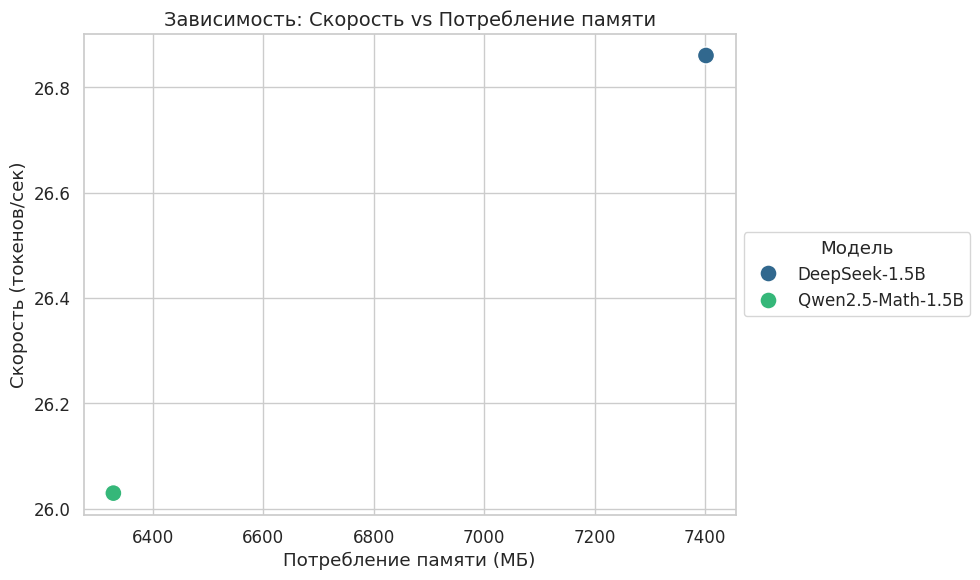

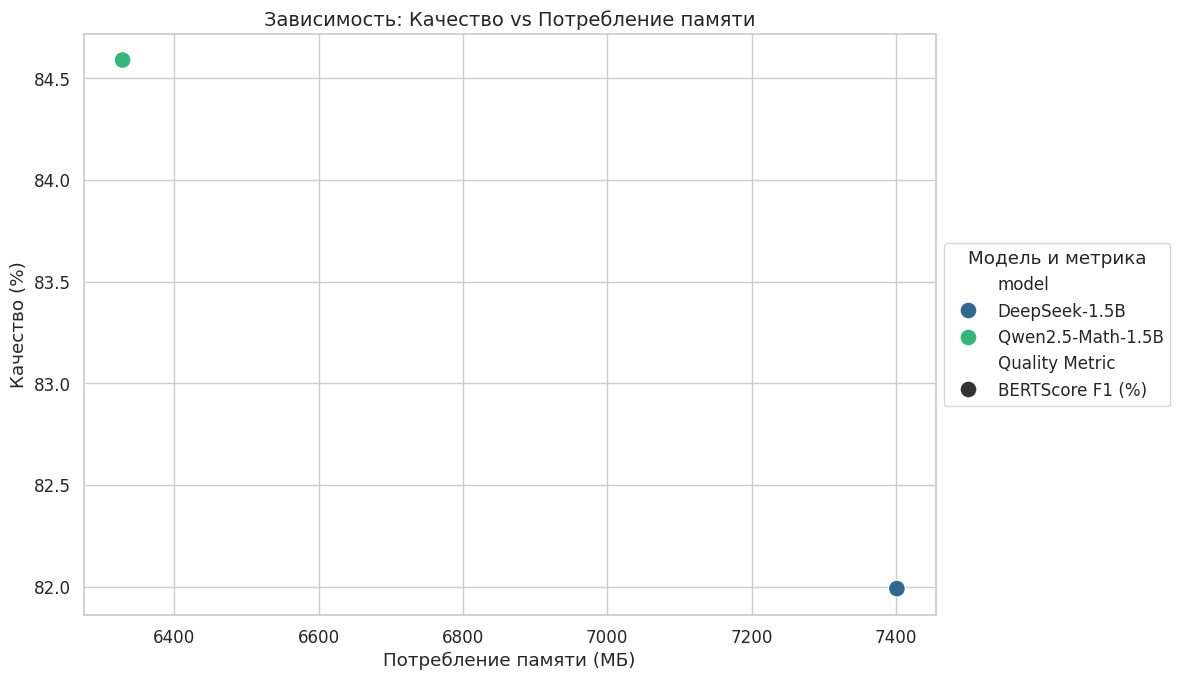

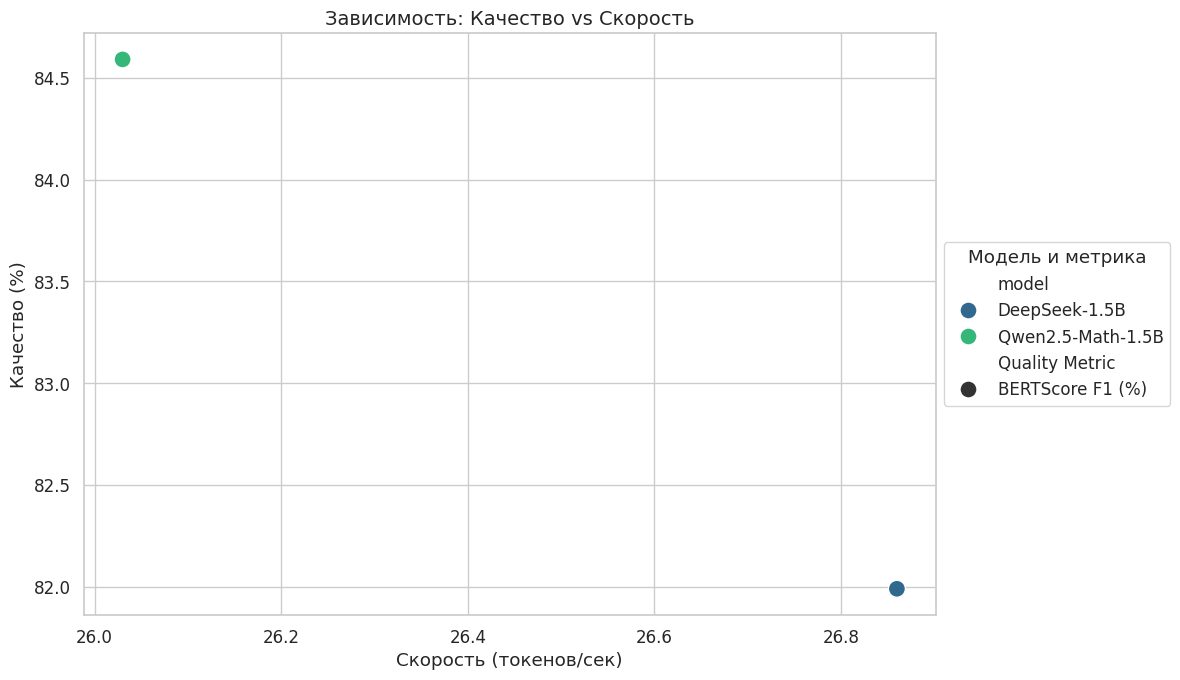

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped_perf_quality,
    x="Memory Usage (MB)",
    y="Speed (tokens/sec)",
    hue="model",
    s=150,
    palette="viridis"
)
plt.title("Зависимость: Скорость vs Потребление памяти", fontsize=14)
plt.xlabel("Потребление памяти (МБ)")
plt.ylabel("Скорость (токенов/сек)")
plt.legend(title="Модель", loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
# Quality vs Memory
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=quality_melted,
    x="Memory Usage (MB)",
    y="Score (%)",
    hue="model",
    style="Quality Metric",
    s=150,
    palette="viridis"
)
plt.title("Зависимость: Качество vs Потребление памяти", fontsize=14)
plt.xlabel("Потребление памяти (МБ)")
plt.ylabel("Качество (%)")
plt.legend(title="Модель и метрика", loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
# Quality vs Speed
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=quality_melted,
    x="Speed (tokens/sec)",
    y="Score (%)",
    hue="model",
    style="Quality Metric",
    s=150,
    palette="viridis"
)
plt.title("Зависимость: Качество vs Скорость", fontsize=14)
plt.xlabel("Скорость (токенов/сек)")
plt.ylabel("Качество (%)")
plt.legend(title="Модель и метрика", loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()